# load dependencies

In [11]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy
import os, sys

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS

for rel in ('src', '../src'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if os.path.isdir(p) and p not in sys.path:
        sys.path.insert(0, p)

from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [4]:
path_to_config = '/Users/amir/Desktop/for Abdel/thetaGamma_dev/src/emd_masksift_CA1_config_2500.yml'
config = emd.sift.SiftConfig.from_yaml_file(path_to_config)

In [5]:
path_to_hpc = '/Users/amir/Desktop/for Abdel/thetaGamma_dev/data/HPC_100_CH32_0.continuous.mat'
path_to_states = '/Users/amir/Desktop/for Abdel/thetaGamma_dev/data/2018-11-02_14-17-36_post_trial5-states.mat'

# load the data

In [19]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

In [20]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

Number of detected Tonic intrevals:30
Number of detected Tonic intrevals after threshold:30


In [21]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

# plot the power contents of imfs

In [22]:
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt

def imf_psd_zscore(imfs, fs, fmin=1, fmax=200, nperseg=None):
    if imfs.ndim == 1:
        imfs = imfs[:, None]
    n = imfs.shape[0]
    if nperseg is None:
        nperseg = min(4*fs, n)  # ~4 s windows
    freqs_list, z_list, peaks = [], [], []
    for j in range(imfs.shape[1]):
        f, Pxx = welch(imfs[:, j], fs=fs, nperseg=nperseg, noverlap=nperseg//2)
        m = (f >= fmin) & (f <= fmax)
        f, Pxx = f[m], Pxx[m]
        z = (Pxx - Pxx.mean()) / (Pxx.std(ddof=0) + 1e-12)  # z-score per IMF
        freqs_list.append(f); z_list.append(z)
        peaks.append(f[np.argmax(Pxx)])
    return freqs_list, z_list, np.asarray(peaks)

def plot_panelB(ax, imfs, fs, title):
    freqs_list, z_list, peaks = imf_psd_zscore(imfs, fs)
    cmap = plt.get_cmap('tab10')
    for j, (f, z) in enumerate(zip(freqs_list, z_list)):
        c = cmap(j % 10)
        ax.plot(f, z, color=c, lw=2, label=f'IMF #{j+1}')
        pf = peaks[j]
        z_pf = z[np.argmin(np.abs(f - pf))]
        ax.text(pf, z_pf + 0.8, f'{pf:.1f} Hz', color=c, fontsize=9, ha='center')
    ax.set_xscale('log')
    ax.set_xlim(1, 200)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_title(title)
    ax.grid(True, which='both', ls='--', alpha=0.3)

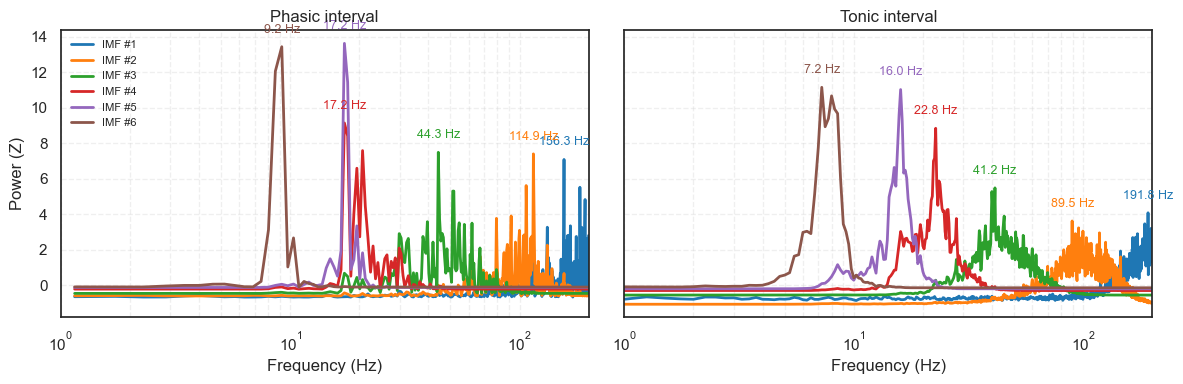

In [24]:
# Choose one interval from each set (adjust indices if desired)
ph_idx = 2
to_idx = 2
fs_use = int(fs)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plot_panelB(axes[0], phasic_imfs[ph_idx], fs_use, 'Phasic interval')
plot_panelB(axes[1], tonic_imfs[to_idx], fs_use, 'Tonic interval')
axes[0].set_ylabel('Power (Z)')
axes[0].legend(frameon=False, fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
def extract_cycle_info(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  raw_wavelets = []
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']
    print(len(cycle_data['theta_imf']))
    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
    # Check if any cycles satisfy the conditions
    if all_cycles is None or all_cycles.chain_vect.size == 0:
        print("No cycles satisfy the conditions.")
        return pd.DataFrame(), pd.DataFrame(), []
    
    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    raw_wavelets.append(raw_data)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    # Compute mode frequency for each cycle
    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs, raw_wavelets

In [66]:
phasic_waveforms, phasic_trials, phasic_FPPs, phasic_raw_wavelets = extract_cycle_info(phasic_imfs, phasic_imfs_freqs)
tonic_waveforms, tonic_trials, tonic_FPPs, tonic_raw_wavelets = extract_cycle_info(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
3050
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
5075
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
4350
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
5595
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
8730
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
8250
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
8950
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
5500
 Checking 

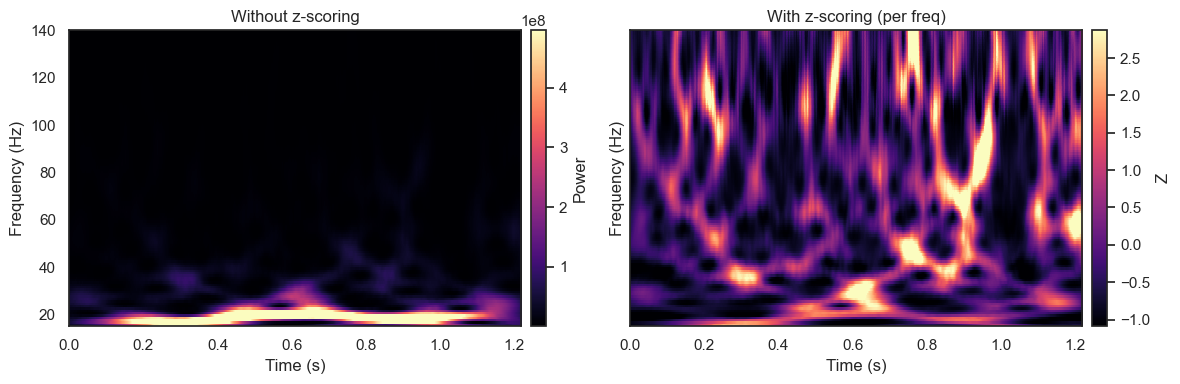

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# pick which interval to visualize
idx = 0      # interval index
W = phasic_raw_wavelets[idx]   # or tonic_raw_wavelets[idx] if you want tonic
fs = 2500
freqs = np.arange(15, 141)

def prep_tfr(tfr, zscore=False):
    X = np.asarray(tfr, float)
    if zscore:
        mu = X.mean(axis=1, keepdims=True)
        sd = X.std(axis=1, keepdims=True) + 1e-12
        X = (X - mu) / sd
    return X

def plot_tfr(ax, tfr, fs, freqs, title, cmap='magma', vmin=None, vmax=None):
    n_freqs, n_time = tfr.shape
    t = np.arange(n_time) / fs
    im = ax.imshow(tfr, aspect='auto', origin='lower',
                   extent=[t[0], t[-1], freqs[0], freqs[-1]],
                   cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    return im

# prepare both versions
W_raw = prep_tfr(W, zscore=False)
W_z   = prep_tfr(W, zscore=True)

# consistent color scales
vmin_raw, vmax_raw = np.percentile(W_raw, [2, 98])
vmin_z, vmax_z     = np.percentile(W_z, [2, 98])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

im0 = plot_tfr(axes[0], W_raw, fs, freqs, 'Without z-scoring', vmin=vmin_raw, vmax=vmax_raw)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02, label='Power')

im1 = plot_tfr(axes[1], W_z, fs, freqs, 'With z-scoring (per freq)', vmin=vmin_z, vmax=vmax_z)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02, label='Z')

plt.tight_layout()
plt.show()


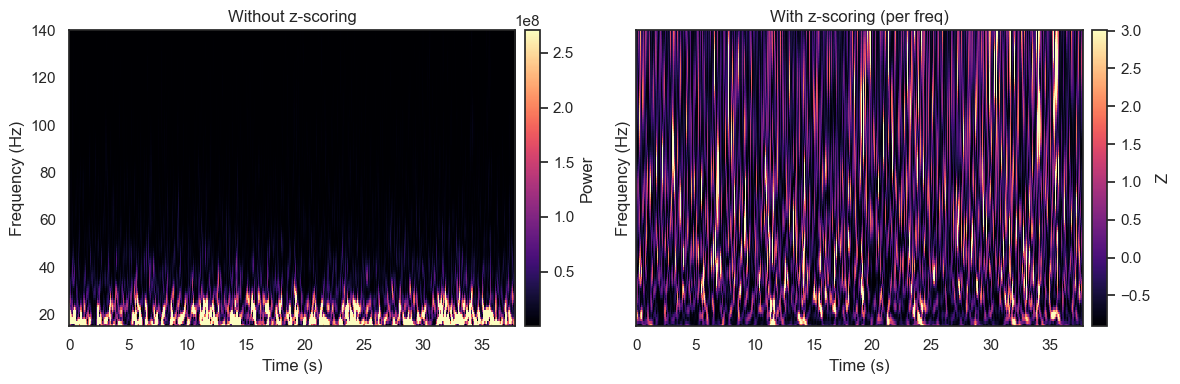

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# pick which interval to visualize
idx = 2       # interval index
W = tonic_raw_wavelets[idx]   # or tonic_raw_wavelets[idx] if you want tonic
fs = 2500
freqs = np.arange(15, 141)

def prep_tfr(tfr, zscore=False):
    X = np.asarray(tfr, float)
    if zscore:
        mu = X.mean(axis=1, keepdims=True)
        sd = X.std(axis=1, keepdims=True) + 1e-12
        X = (X - mu) / sd
    return X

def plot_tfr(ax, tfr, fs, freqs, title, cmap='magma', vmin=None, vmax=None):
    n_freqs, n_time = tfr.shape
    t = np.arange(n_time) / fs
    im = ax.imshow(tfr, aspect='auto', origin='lower',
                   extent=[t[0], t[-1], freqs[0], freqs[-1]],
                   cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    return im

# prepare both versions
W_raw = prep_tfr(W, zscore=False)
W_z   = prep_tfr(W, zscore=True)

# consistent color scales
vmin_raw, vmax_raw = np.percentile(W_raw, [2, 98])
vmin_z, vmax_z     = np.percentile(W_z, [2, 98])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

im0 = plot_tfr(axes[0], W_raw, fs, freqs, 'Without z-scoring', vmin=vmin_raw, vmax=vmax_raw)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02, label='Power')

im1 = plot_tfr(axes[1], W_z, fs, freqs, 'With z-scoring (per freq)', vmin=vmin_z, vmax=vmax_z)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02, label='Z')

plt.tight_layout()
plt.show()


In [23]:
# ========= NEW HELPERS (non-invasive) =========
import numpy as np
import warnings
import pandas as pd
import sails
import emd
from emd.spectra import frequency_transform  # for Hilbert IP/IF/IA

def _choose_theta_imf(imf, fs, theta_band=(5.0, 12.0), min_inband_frac=0.60):
    """
    Only used as a fallback if IMF index 5 is not valid/theta-like.
    Prefers IMFs spending >= min_inband_frac inside theta_band; else nearest median IF.
    """
    n_imf = imf.shape[1]
    lo, hi = theta_band
    IFs = []
    for k in range(n_imf):
        _, IF_k, _ = frequency_transform(imf[:, k], fs, 'hilbert')
        IFs.append(IF_k)
    IFs = np.vstack(IFs)                     # [n_imf, n_samples]
    frac_inband = ((IFs >= lo) & (IFs <= hi)).mean(axis=1)
    med_if = np.median(IFs, axis=1)
    band_center = 0.5 * (lo + hi)
    cand = np.where(frac_inband >= min_inband_frac)[0]
    if cand.size:
        return int(cand[np.argmin(np.abs(med_if[cand] - band_center))])
    warnings.warn("No IMF met min_inband_frac; using IMF with median IF closest to theta center.")
    return int(np.argmin(np.abs(med_if - band_center)))

def _cycle_time_indices_from_bins(cycles_inds):
    """
    Your FPP path gives phase-binned indices per cycle.
    Convert each cycle’s bins to a flat, unique list of time indices.
    """
    out = []
    for cyc in cycles_inds:
        arr = np.asarray(cyc)
        flat = arr.ravel()
        flat = flat[np.isfinite(flat)]
        if flat.size == 0:
            out.append(np.array([], dtype=int))
            continue
        flat = flat.astype(int, copy=False)
        flat = flat[(flat >= 0)]
        out.append(np.unique(flat))
    return out

def _spectral_signatures_time_mean(supra_sig, fs, cycle_time_idx_list,
                                   freqs=np.arange(15, 141, 1), wavelet_ncycles=5):
    """
    Paper-faithful signatures: Morlet power on supra-theta signal (15–140 Hz),
    then per-cycle MEAN across time samples inside that cycle (no phase binning / z-scoring).
    Returns:
        sigs  -> (n_cycles, n_freq)
        tf    -> (n_freq, n_time) full time-frequency power (useful for debugging)
    """
    tf = sails.wavelet.morlet(
        supra_sig, freqs=freqs, sample_rate=fs,
        ncycles=wavelet_ncycles, ret_mode='power', normalise=None
    )
    sigs = []
    T = tf.shape[1]
    for tids in cycle_time_idx_list:
        tids = np.asarray(tids)
        tids = tids[(tids >= 0) & (tids < T)]
        if tids.size == 0:
            sigs.append(np.full(len(freqs), np.nan))
        else:
            sigs.append(tf[:, tids].mean(axis=1))
    if len(sigs) == 0:
        return np.zeros((0, len(freqs))), tf
    return np.vstack(sigs), tf

def prepare_time_signatures(imfs, imf_frequencies, lfp_segments,
                            fs=2500, theta_imf_index_prefer=5,
                            theta_band=(5.0, 12.0),
                            freq_vec=np.arange(15, 141, 1)):
    """
    Produces per-cycle spectral signatures (15–140 Hz) using supra-theta = sum of supra-theta IMFs.
    """

    time_signatures_list = []

    for idx, imf in enumerate(imfs):
        # 1) pick theta IMF index (prefer fixed, fallback if needed)
        if imf.shape[1] > theta_imf_index_prefer:
            theta_idx = theta_imf_index_prefer
        else:
            theta_idx = _choose_theta_imf(imf, fs, theta_band=theta_band)

        # 2) get cycles with your conditions
        cycle_data = get_cycle_data(imf[:, theta_idx], fs=fs)
        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/12
        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']
        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
        if all_cycles is None or all_cycles.chain_vect.size == 0:
            time_signatures_list.append(np.zeros((0, len(freq_vec))))
            continue

        subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_cycles_df['index'].values

        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds = arrange_cycle_inds(all_cycles_inds)
        tids = _cycle_time_indices_from_bins(cycles_inds)

        # 3) supra-theta = sum of supra-theta IMFs (paper-style definition)
        freqs = imf_frequencies[idx]
        _, theta_mask, supra_mask = tg_split(freqs, theta_band)
        theta_imf = imf[:, theta_mask].sum(axis=1) if np.any(theta_mask) else imf[:, theta_idx]
        supra_theta_sig = imf[:, supra_mask].sum(axis=1) if np.any(supra_mask) else np.zeros_like(theta_imf)

        # 4) per-cycle time-mean spectral signatures
        sigs_time, _tf = _spectral_signatures_time_mean(
            supra_theta_sig, fs, tids, freqs=freq_vec, wavelet_ncycles=5
        )
        time_signatures_list.append(sigs_time)

    return time_signatures_list

def extract_data_for_rat(rat_id):
    # Define the base path to OS Basic datasets
    base_path = '/Users/amir/Desktop/for Abdel/OS Basic'
    fs = 2500  # Sample frequency

    # Initialize empty DataFrames for concatenation across all recordings and trials for the specified rat
    all_combined_waveforms = pd.DataFrame()
    all_combined_trials = pd.DataFrame()
    all_phasic_fpps = []
    all_tonic_fpps = []

    all_phasic_time_sigs = []
    all_tonic_time_sigs = []

    rat_path = os.path.join(base_path, str(rat_id))

    # Check if the specified rat folder exists
    if not os.path.isdir(rat_path):
        print(f"Rat folder {rat_id} does not exist.")
        return None, None

    # List all recording folders in the rat directory
    recording_folders = [
        f for f in os.listdir(rat_path)
        if os.path.isdir(os.path.join(rat_path, f))
    ]

    if not recording_folders:
        print(f"No recording folders found for Rat {rat_id}.")
        return None, None

    # Loop over each recording folder
    for recording_folder in recording_folders:
        print(f"Processing recording folder: {recording_folder}")
        recording_path = os.path.join(rat_path, recording_folder)

        # Use regular expressions to parse the folder name
        match = re.match(r'^Rat-OS-Ephys_(Rat\d+)_SD(\d+)_([\w-]+)_([\d-]+)$', recording_folder)
        if not match:
            print(f"Unexpected folder name format: {recording_folder}. Skipping...")
            continue

        rat_id_part = match.group(1)       # e.g., 'Rat6'
        sd_number = match.group(2)         # e.g., '4'
        condition = match.group(3)         # e.g., 'CON'
        date_part = match.group(4)         # e.g., '22-02-2018'

        rat_id_from_folder = ''.join(filter(str.isdigit, rat_id_part))

        # Check if rat_id_from_folder matches rat_id
        if rat_id_from_folder != str(rat_id):
            print(f"Rat ID mismatch in folder {recording_folder}. Expected Rat{rat_id}, found Rat{rat_id_from_folder}. Skipping...")
            continue

        # Detect all trial folders and filter for post_trial2 to post_trial5, considering various folder name formats
        trial_folders = [
            f for f in os.listdir(recording_path)
            if os.path.isdir(os.path.join(recording_path, f)) and
            re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', f)
        ]

        if not trial_folders:
            print(f"No trial folders found in {recording_folder}.")
            continue

        for trial_folder in trial_folders:
            print(f"Processing trial folder: {trial_folder}")
            trial_path = os.path.join(recording_path, trial_folder)

            # Search for LFP and state files in the trial folder
            lfp_file = None
            state_file = None

            for file_name in os.listdir(trial_path):
                if 'HPC' in file_name and file_name.endswith('.mat'):
                    lfp_file = os.path.join(trial_path, file_name)
                elif 'states' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)
                elif 'States' in file_name and file_name.endswith('.mat'):
                    state_file = os.path.join(trial_path, file_name)

            # Ensure both LFP and state files were found
            if not lfp_file or not state_file:
                print(f"Missing LFP or state file in {trial_path}. Skipping...")
                continue

            # Extract trial number from folder name
            trial_number_match = re.search(r'(?i)post[\-_]?trial[\-_]?([2-5])', trial_folder)
            if trial_number_match:
                trial_number = int(trial_number_match.group(1))
            else:
                print(f"Unable to extract trial number from folder name: {trial_folder}. Skipping...")
                continue

            # Load data using custom functions
            try:
                lfpHPC, hypno, _ = get_data(lfp_file, state_file)

                # Extract phasic and tonic intervals, handling cases with no REM sleep
                try:
                    phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)
                except ValueError as e:
                    print(f"No REM sleep found in {trial_folder} for Rat {rat_id}, Condition {condition}. Filling with empty intervals.")
                    phasic_interval, tonic_interval, lfp = [[], [], []]

                # Extract IMFs and frequencies for phasic and tonic intervals if intervals are not empty
                if phasic_interval and tonic_interval:
                    # Get IMFs + imf_freqs + raw segments per interval
                    tonic_imfs, tonic_freqs, tonic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, tonic_interval, config, return_imfs_freqs=True)
                    phasic_imfs, phasic_freqs, phasic_lpf = extract_imfs_by_pt_intervals(
                        lfp, fs, phasic_interval, config, return_imfs_freqs=True)

                    # === existing path: FPP/UMAP ===
                    phasic_waveforms, phasic_trials, phasic_fpps, _ = extract_cycle_info(phasic_imfs, phasic_freqs)
                    tonic_waveforms,  tonic_trials,  tonic_fpps, _  = extract_cycle_info(tonic_imfs,  tonic_freqs)

                    # === NEW parallel path: 15–140 Hz time-mean spectral signatures ===
                    phasic_time_sigs = prepare_time_signatures(
                        phasic_imfs, phasic_freqs, phasic_lpf, fs=fs,
                        theta_imf_index_prefer=5, theta_band=(5,12),
                        freq_vec=np.arange(15,141,1)
                    )
                    tonic_time_sigs = prepare_time_signatures(
                        tonic_imfs, tonic_freqs, tonic_lpf, fs=fs,
                        theta_imf_index_prefer=5, theta_band=(5,12),
                        freq_vec=np.arange(15,141,1)
                    )

                    # Add metadata columns, including cycle type labels
                    for df in [phasic_waveforms, phasic_trials]:
                        df['rat_id'] = rat_id
                        df['condition'] = condition
                        df['trial'] = trial_number
                        df['cycle_type'] = 'phasic'
                        df['SD'] = sd_number
                        df['date'] = date_part

                    for df in [tonic_waveforms, tonic_trials]:
                        df['rat_id'] = rat_id
                        df['condition'] = condition
                        df['trial'] = trial_number
                        df['cycle_type'] = 'tonic'
                        df['SD'] = sd_number
                        df['date'] = date_part

                    # Concatenate into combined DataFrames / lists
                    all_combined_waveforms = pd.concat(
                        [all_combined_waveforms, phasic_waveforms, tonic_waveforms], ignore_index=True)
                    all_combined_trials = pd.concat(
                        [all_combined_trials, phasic_trials, tonic_trials], ignore_index=True)
                    all_phasic_fpps.extend(phasic_fpps)
                    all_tonic_fpps.extend(tonic_fpps)

                    # NEW: collect time-mean signature sets
                    all_phasic_time_sigs.extend(phasic_time_sigs)
                    all_tonic_time_sigs.extend(tonic_time_sigs)

            except FileNotFoundError:
                print(f"Data not found in {trial_path}. Skipping...")

    if all_combined_waveforms.empty:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None

    # NOTE: we append two NEW return values (time-mean signatures) at the end.
    return (all_combined_waveforms, all_combined_trials,
            all_phasic_fpps, all_tonic_fpps,
            all_phasic_time_sigs, all_tonic_time_sigs)

In [25]:
rat_id = '11'
waveforms_df,trials_df, all_phasic_FPPs, all_tonic_FPPs, phasic_time_signatures, tonic_time_signatures= extract_data_for_rat(rat_id)

print(f"FPPs — phasic intervals: {len(all_phasic_FPPs)}, tonic intervals: {len(all_tonic_FPPs)}")
print(f"Time-mean signatures — phasic intervals: {len(phasic_time_signatures)}, tonic intervals: {len(tonic_time_signatures)}")

Processing recording folder: Rat-OS-Ephys_Rat11_SD1_CON_29-10-2018
Processing trial folder: 2018-10-29_12-41-45_Post_Trial2
There was 0 in the dataset
Number of detected Tonic intrevals:7
Number of detected Tonic intrevals after threshold:7


KeyboardInterrupt: 

In [ ]:
import os, pickle, gzip
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- paths ----------
def _data_dir():
    # notebook lives in ./exploration → go up one → ./data
    return (Path(os.getcwd()).resolve().parent / "data")

# ---------- SAVE (pickle + npz) ----------
def save_rat_outputs_simple(
    rat_id,
    waveforms_df, trials_df,
    all_phasic_FPPs, all_tonic_FPPs,
    phasic_time_signatures, tonic_time_signatures,
    subfolder=None
):
    base = _data_dir() / (subfolder or f"rat_{rat_id}")
    base.mkdir(parents=True, exist_ok=True)

    # DataFrames → Pickle (optionally gzipped)
    waveforms_df.to_pickle(base / "waveforms.pkl")
    trials_df.to_pickle(base / "trials.pkl")

    # Python lists / ragged arrays → NPZ (compressed) using object arrays
    np.savez_compressed(
        base / "extras_arrays.npz",
        phasic_FPPs=np.array(all_phasic_FPPs, dtype=object),
        tonic_FPPs=np.array(all_tonic_FPPs, dtype=object),
        phasic_time_signatures=np.array(phasic_time_signatures, dtype=object),
        tonic_time_signatures=np.array(tonic_time_signatures, dtype=object),
        allow_pickle=True
    )

    print(f"✓ Saved to {base}")
    return base

In [13]:
# Save to local

# rat_id = "11"
# save_dir = save_rat_outputs_simple(
#     rat_id,
#     waveforms_df, trials_df,
#     all_phasic_FPPs, all_tonic_FPPs,
#     phasic_time_signatures, tonic_time_signatures
# )

In [14]:
# ---------- LOAD ----------

def _data_dir():
    # notebook lives in ./exploration → go up one → ./data
    return (Path(os.getcwd()).resolve().parent / "data")

def load_rat_outputs_simple(rat_id, subfolder=None):
    base = _data_dir() / (subfolder or f"rat_{rat_id}")
    if not base.exists():
        raise FileNotFoundError(f"Missing folder: {base}")

    waveforms_df = pd.read_pickle(base / "waveforms.pkl")
    trials_df    = pd.read_pickle(base / "trials.pkl")

    npz = np.load(base / "extras_arrays.npz", allow_pickle=True)
    all_phasic_FPPs        = npz["phasic_FPPs"].tolist()
    all_tonic_FPPs         = npz["tonic_FPPs"].tolist()
    phasic_time_signatures = npz["phasic_time_signatures"].tolist()
    tonic_time_signatures  = npz["tonic_time_signatures"].tolist()

    return (waveforms_df, trials_df,
            all_phasic_FPPs, all_tonic_FPPs,
            phasic_time_signatures, tonic_time_signatures)

In [15]:
# load from local
(waveforms_df, trials_df,
 all_phasic_FPPs, all_tonic_FPPs,
 phasic_time_signatures, tonic_time_signatures) = load_rat_outputs_simple("11")

In [105]:
# ====== CELL: PCA→ICA on 15–140 Hz time-mean signatures + outputs ======
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt

# -------------------------
# 0) config
# -------------------------
freq_vec = np.arange(15, 141, 1)     # 15–140 Hz
n_pca = 5                             # paper-style default
zscore_features = False                # z-score across cycles (per frequency)
mad_k = 2.0                           # robust threshold factor

# -------------------------
# 1) flatten helpers
# -------------------------
def _flatten_sig_list(sig_list, label):
    """sig_list: list of arrays (n_cycles_i × n_freq). Returns (X, meta_rows)"""
    rows = []
    meta = []
    for i, arr in enumerate(sig_list):
        if not isinstance(arr, np.ndarray) or arr.size == 0:
            continue
        # keep only rows with all finite values
        mask = np.isfinite(arr).all(axis=1)
        Xi = arr[mask]
        rows.append(Xi)
        # metadata per cycle
        for j in range(Xi.shape[0]):
            meta.append({"interval_idx": i, "cycle_idx_in_interval": j, "cycle_type": label})
    if len(rows) == 0:
        return np.zeros((0, len(freq_vec))), []
    X = np.vstack(rows)
    return X, meta

X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
X_tonic,  meta_tonic  = _flatten_sig_list(tonic_time_signatures,  "tonic")

X = np.vstack([X_phasic, X_tonic])
meta = meta_phasic + meta_tonic
if X.shape[0] == 0:
    raise RuntimeError("No valid cycles in time-mean signatures. Check earlier steps.")

# -------------------------
# 2) feature normalization (optional but recommended)
# -------------------------
if zscore_features:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
    Xz = (X - mu) / sd
else:
    Xz = X

# -------------------------
# 3) PCA → ICA
# -------------------------
pca = PCA(n_components=n_pca, random_state=42)
Z = pca.fit_transform(Xz)             # (n_cycles × n_pca)
ica = FastICA(n_components=n_pca, random_state=42, max_iter=1000, tol=1e-3)
S = ica.fit_transform(Z)              # (n_cycles × n_pca) = cycle-wise tSC strengths (pre sign-fix)

# Map ICA comps back to frequency space (weights per frequency bin)
# tSC weights shape: (n_pca × n_freq)
W_freq = ica.components_ @ pca.components_

# -------------------------
# 4) fix arbitrary ICA sign: make mean projection positive
# -------------------------
mean_proj = S.mean(axis=0, keepdims=True)  # (1 × n_pca)
signs = np.sign(mean_proj)
signs[signs == 0] = 1
S *= signs                                  # flip strengths
W_freq *= signs.T                           # flip weights to match

# -------------------------
# 5) robust strong-cycle thresholds (per component)
# -------------------------
def _mad_threshold(x, k=2.0):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    # gaussian-consistent scale ~ mad/0.6745; many groups just use med + k*MAD
    return med + k * (mad / 0.6745)

absS = np.abs(S)
thr_per_comp = np.array([_mad_threshold(absS[:, k], k=mad_k) for k in range(n_pca)])

# # -------------------------
# # 6) component peak frequencies (paper-style)
# # -------------------------
# # peak = argmax |weight| per component
# peak_idx = np.argmax(np.abs(W_freq), axis=1)
# component_peaks_hz = freq_vec[peak_idx]

# # -------------------------
# # 7) per-cycle labels & mode frequency
# # -------------------------
# # tSC assignment = argmax |strength|
# labels_0based = np.argmax(absS, axis=1)
# labels_1based = labels_0based + 1

# # mode frequency per cycle = argmax over frequency of the cycle signature (pre-zscored)
# mode_idx = np.argmax(X, axis=1)
# mode_freq_hz = freq_vec[mode_idx]

# # strong flags per component
# strong_flags = absS >= thr_per_comp  # (n_cycles × n_pca)

# # -------------------------
# # 8) tidy DataFrame of cycles
# # -------------------------
# cycles_df = pd.DataFrame(meta)
# cycles_df["mode_freq_hz"] = mode_freq_hz
# cycles_df["tSC_label"] = labels_1based
# for k in range(n_pca):
#     cycles_df[f"tSC{k+1}_strength"] = S[:, k]
#     cycles_df[f"tSC{k+1}_strong"] = strong_flags[:, k]

# # Attach some globals in a dict you can keep
# tSC_results = {
#     "freq_vec": freq_vec,
#     "pca": pca,
#     "ica": ica,
#     "weights_freq": W_freq,              # shape (n_pca × n_freq)
#     "component_peaks_hz": component_peaks_hz,
#     "strengths": S,                      # (n_cycles × n_pca)
#     "thresholds_abs_strength": thr_per_comp,
#     "X_cycles": X,                       # signatures used (after filtering)
#     "meta": meta
# }

# print("=== PCA/ICA done ===")
# print("n cycles:", X.shape[0], "| n freq:", X.shape[1], "| n_pca:", n_pca)
# print("Explained variance by PCs:", np.round(pca.explained_variance_ratio_, 3))
# print("tSC component peak freqs (Hz):", component_peaks_hz)
# print("Strong-cycle thresholds (|strength|):", np.round(thr_per_comp, 3))

In [109]:
def plot_mode_freq_histograms_per_component(df, freq_bins=np.linspace(15,140,20), ymax=0.25):
    comps = sorted(df["tSC_label"].unique())
    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            vals = sub.loc[sub["cycle_type"] == ctype, "mode_freq_hz_proj"].to_numpy()
            vals = vals[np.isfinite(vals)]
            if vals.size > 0:
                weights = np.ones_like(vals, dtype=float) / vals.size
                ax.hist(vals, bins=freq_bins, weights=weights, alpha=0.8)
            ax.set_xlim(15, 140); ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)"); ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")
        plt.tight_layout(); plt.show()

In [115]:
from sklearn.decomposition import PCA, FastICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.ndimage import gaussian_filter1d
    _HAS_SCI = True
except Exception:
    _HAS_SCI = False


def run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                     n_pca=5, freq_vec=np.arange(15,141,1),
                     zscore_features=True, mad_k=2.0,
                     weighted_alpha=0.4,      # support mask for weighted modes; set None to disable
                     ignore_edge_bins=1       # don’t pick first/last bin
                    ):
    """
    Returns cycles_df with:
      - mode_freq_hz_featZ
      - mode_freq_hz_featZ_smooth       (5 Hz reflect)
      - mode_freq_hz_featZ_smooth10     (10 Hz reflect)
      - mode_freq_hz_featZ_smooth5_pad  (5 Hz pad0)
      - mode_freq_hz_featZ_smooth10_pad (10 Hz pad0)
      - *_strong versions (computed only for cycles above MAD threshold)
      - mode_freq_hz_featZw             (feature-Z * |W_k|)
      - mode_freq_hz_proj               (within-cycle Z * |W_k|)
    """

    # ---------------- 1) flatten ----------------
    def _flatten_sig_list(sig_list, label):
        rows, meta = [], []
        for i, arr in enumerate(sig_list):
            if not isinstance(arr, np.ndarray) or arr.size == 0:
                continue
            mask = np.isfinite(arr).all(axis=1)
            Xi = arr[mask]
            if Xi.size == 0:
                continue
            rows.append(Xi)
            for j in range(Xi.shape[0]):
                meta.append({"interval_idx": i, "cycle_idx_in_interval": j, "cycle_type": label})
        if len(rows) == 0:
            return np.zeros((0, len(freq_vec))), []
        return np.vstack(rows), meta

    X_phasic, meta_phasic = _flatten_sig_list(phasic_time_signatures, "phasic")
    X_tonic,  meta_tonic  = _flatten_sig_list(tonic_time_signatures, "tonic")
    X = np.vstack([X_phasic, X_tonic]); meta = meta_phasic + meta_tonic
    if X.shape[0] == 0:
        raise RuntimeError("No valid cycles to analyze.")

    # ---------------- 2) feature z-score ----------------
    if zscore_features:
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
        Xz = (X - mu) / sd
    else:
        Xz = X

    # ---- smoothing helper ----
    def _smooth_rows(mat, sigma_hz, mode="reflect"):
        if _HAS_SCI:
            return gaussian_filter1d(mat, sigma=float(sigma_hz), axis=1, mode=mode)
        # fallback conv
        sigma = float(sigma_hz)
        rad = int(np.ceil(4 * sigma))
        kx = np.arange(-rad, rad + 1)
        ker = np.exp(-(kx**2) / (2 * sigma**2))
        ker /= ker.sum()
        pad = rad
        out = np.empty_like(mat)
        for i in range(mat.shape[0]):
            row = mat[i]
            if mode == "reflect":
                row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
            elif mode == "constant":
                row_pad = np.r_[np.zeros(pad), row, np.zeros(pad)]
            else:
                row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
            out[i] = np.convolve(row_pad, ker, mode="same")[pad:-pad]
        return out

    # ---------------- 2b) smoothed versions ----------------
    Xz_smooth5_ref  = _smooth_rows(Xz,  5.0, mode="reflect")
    Xz_smooth10_ref = _smooth_rows(Xz, 10.0, mode="reflect")
    Xz_smooth5_pad  = _smooth_rows(Xz,  5.0, mode="constant")
    Xz_smooth10_pad = _smooth_rows(Xz, 10.0, mode="constant")

    # ---------------- 3) PCA → ICA ----------------
    pca = PCA(n_components=n_pca, random_state=42)
    Z = pca.fit_transform(Xz)
    ica = FastICA(n_components=n_pca, random_state=42, max_iter=1000, tol=1e-3)
    S  = ica.fit_transform(Z)
    W_freq = ica.components_ @ pca.components_

    # ---------------- 4) sign fix ----------------
    mean_proj = S.mean(axis=0, keepdims=True)
    signs = np.sign(mean_proj); signs[signs == 0] = 1
    S *= signs; W_freq *= signs.T

    # ---------------- 5) MAD thresholds ----------------
    def _mad_threshold(x, k=2.0):
        med = np.median(x); mad = np.median(np.abs(x - med)) + 1e-12
        return med + k * (mad / 0.6745)
    absS = np.abs(S)
    thr_per_comp = np.array([_mad_threshold(absS[:, k], k=mad_k) for k in range(n_pca)])
    labels_0based = np.argmax(absS, axis=1)

    strong_mask = np.zeros_like(labels_0based, dtype=bool)
    for k in range(n_pca):
        strong_mask |= (labels_0based == k) & (absS[:, k] >= thr_per_comp[k])

    # ---------------- helper: mode extraction ----------------
    def _mode_from_mat(mat):
        L, R = ignore_edge_bins, (mat.shape[1] - ignore_edge_bins)
        if R <= L:
            idx = np.argmax(mat, axis=1)
        else:
            idx = np.argmax(mat[:, L:R], axis=1) + L
        return freq_vec[idx]

    # ---------------- A) modes ----------------
    mode_freq_hz_featZ          = _mode_from_mat(Xz)
    mode_freq_hz_featZ_smooth   = _mode_from_mat(Xz_smooth5_ref)
    mode_freq_hz_featZ_smooth10 = _mode_from_mat(Xz_smooth10_ref)
    mode_freq_hz_featZ_smooth5_pad  = _mode_from_mat(Xz_smooth5_pad)
    mode_freq_hz_featZ_smooth10_pad = _mode_from_mat(Xz_smooth10_pad)

    # -------- A_strong: restrict to strong cycles --------
    def _mode_strong(mat):
        modes = np.full(mat.shape[0], np.nan)
        modes[strong_mask] = _mode_from_mat(mat[strong_mask])
        return modes

    mode_freq_hz_featZ_strong          = _mode_strong(Xz)
    mode_freq_hz_featZ_smooth_strong   = _mode_strong(Xz_smooth5_ref)
    mode_freq_hz_featZ_smooth10_strong = _mode_strong(Xz_smooth10_ref)

    # ---------------- B) weighted modes ----------------
    def mode_from_feature_z_weighted(Xz_like, W_freq, labels_0based, freq_vec,
                                     avoid_edge_bins=1, alpha=None):
        n_cycles, n_freq = Xz_like.shape
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        modes = np.empty(n_cycles, dtype=float)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                m = (w >= thr)
                if m.sum() >= 3:
                    w[~m] = 0.0
            y = Xz_like[i] * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg))
            idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_featZ_weighted = mode_from_feature_z_weighted(
        Xz, W_freq, labels_0based, freq_vec,
        avoid_edge_bins=ignore_edge_bins, alpha=weighted_alpha
    )

    # ---------------- C) within-cycle-Z + weights ----------------
    eps = 1e-12
    def tsc_weighted_mode_freq(X, W_freq, labels_0based, freq_vec,
                               avoid_edge_bins=1, alpha=0.4):
        n_cycles, n_freq = X.shape
        modes = np.empty(n_cycles, dtype=float)
        lo = avoid_edge_bins; hi = n_freq - avoid_edge_bins
        use_slice = slice(lo, hi) if hi > lo else slice(0, n_freq)
        for i in range(n_cycles):
            k = int(labels_0based[i])
            x = X[i]
            xz = (x - x.mean()) / (x.std(ddof=1) + eps)
            w = np.abs(W_freq[k]).copy()
            if alpha is not None:
                thr = alpha * np.max(w)
                mask = w >= thr
                if mask.sum() >= 3:
                    w[~mask] = 0.0
            y = xz * w
            yseg = y[use_slice]
            idx_rel = int(np.argmax(yseg))
            idx = (lo + idx_rel) if hi > lo else idx_rel
            modes[i] = freq_vec[idx]
        return modes

    mode_freq_hz_proj = tsc_weighted_mode_freq(
        X, W_freq, labels_0based, freq_vec,
        avoid_edge_bins=ignore_edge_bins, alpha=weighted_alpha
    )

    # ---------------- 7) package ----------------
    cycles_df = pd.DataFrame(meta)
    cycles_df["tSC_label"]                   = labels_0based + 1
    cycles_df["mode_freq_hz_featZ"]          = mode_freq_hz_featZ
    cycles_df["mode_freq_hz_featZ_smooth"]   = mode_freq_hz_featZ_smooth
    cycles_df["mode_freq_hz_featZ_smooth10"] = mode_freq_hz_featZ_smooth10
    cycles_df["mode_freq_hz_featZ_smooth5_pad"]  = mode_freq_hz_featZ_smooth5_pad
    cycles_df["mode_freq_hz_featZ_smooth10_pad"] = mode_freq_hz_featZ_smooth10_pad
    cycles_df["mode_freq_hz_featZ_strong"]       = mode_freq_hz_featZ_strong
    cycles_df["mode_freq_hz_featZ_smooth_strong"]= mode_freq_hz_featZ_smooth_strong
    cycles_df["mode_freq_hz_featZ_smooth10_strong"]= mode_freq_hz_featZ_smooth10_strong
    cycles_df["mode_freq_hz_featZw"]         = mode_freq_hz_featZ_weighted
    cycles_df["mode_freq_hz_proj"]           = mode_freq_hz_proj

    for k in range(n_pca):
        cycles_df[f"tSC{k+1}_strength"] = S[:, k]
        cycles_df[f"tSC{k+1}_strong"]   = (absS[:, k] >= thr_per_comp[k])

    tSC_results = {
        "freq_vec": freq_vec, "pca": pca, "ica": ica,
        "weights_freq": W_freq, "strengths": S,
        "thresholds_abs_strength": thr_per_comp,
        "X_cycles": X,
        "X_cycles_featZ": Xz,
        "X_cycles_featZ_smooth":    Xz_smooth5_ref,
        "X_cycles_featZ_smooth10":  Xz_smooth10_ref,
        "X_cycles_featZ_smooth5_pad":  Xz_smooth5_pad,
        "X_cycles_featZ_smooth10_pad": Xz_smooth10_pad,
        "meta": meta
    }

    print("=== PCA/ICA done ===")
    print("n cycles:", X.shape[0])
    print("Mode — featZ (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ']))
    print("Mode — featZ strong (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_strong']))
    print("Mode — featZ 5Hz reflect strong (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth_strong']))
    print("Mode — featZ 10Hz reflect strong (median):", np.nanmedian(cycles_df['mode_freq_hz_featZ_smooth10_strong']))
    return cycles_df, tSC_results

In [116]:
cycles_df, tSC_results = run_tSC_pipeline(phasic_time_signatures, tonic_time_signatures,
                                          n_pca=5, freq_vec=np.arange(15,141,1),
                                          zscore_features=True, mad_k=2.0)

=== PCA/ICA done ===
n cycles: 61171
Mode — featZ (median): 42.0
Mode — featZ strong (median): 58.0
Mode — featZ 5Hz reflect strong (median): 80.0
Mode — featZ 10Hz reflect strong (median): 84.0


In [113]:

# ============================================================
# E) SMALL UTILITIES
# ============================================================

def plot_tSC_weights(weights, freqs):
    plt.figure(figsize=(12, 6))
    
    # Color palette avoiding green - using blues, reds, purples, oranges, browns
    color_palette = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange  
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#bcbd22',  # olive (not green)
        '#17becf',  # cyan
        '#d62728',  # red
        '#ff9896'   # light red
    ]
    
    # Extend palette if needed
    while len(color_palette) < weights.shape[0]:
        color_palette.extend(color_palette)
    
    for k in range(weights.shape[0]):
        w = weights[k]
        pk = freqs[np.argmax(np.abs(w))]
        color = color_palette[k % len(color_palette)]
        plt.plot(freqs, w, label=f"tSC {k+1} (peak {pk:.1f} Hz)", color=color)
        plt.scatter([pk], [w[np.argmax(np.abs(w))]], s=40, color=color)
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mode_freq_histograms_per_component(df, col="mode_freq_hz_proj",
                                            freq_bins=np.linspace(15, 140, 20), ymax=0.25):
    comps = sorted(df["tSC_label"].unique())
    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            vals = sub.loc[sub["cycle_type"] == ctype, col].to_numpy()
            vals = vals[np.isfinite(vals)]
            if vals.size > 0:
                weights = np.ones_like(vals, dtype=float) / vals.size
                ax.hist(vals, bins=freq_bins, weights=weights, alpha=0.8)
            ax.set_xlim(15, 140); ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)"); ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")
        plt.tight_layout(); plt.show()

def print_cycle_counts(cycles_df):
    counts = cycles_df["cycle_type"].value_counts()
    print(f"Phasic cycles: {counts.get('phasic', 0)}")
    print(f"Tonic  cycles: {counts.get('tonic', 0)}")

def plot_cycle_signature(cycle_idx, X_raw, X_z, freq_vec):
    if cycle_idx < 0 or cycle_idx >= X_raw.shape[0]:
        print(f"Invalid cycle_idx {cycle_idx}, max = {X_raw.shape[0]-1}"); return
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(freq_vec, X_raw[cycle_idx], color="black")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Power (a.u.)"); plt.title(f"Cycle {cycle_idx} — Raw signature")
    plt.subplot(1,2,2); plt.plot(freq_vec, X_z[cycle_idx], color="red")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Z-scored Power"); plt.title(f"Cycle {cycle_idx} — Z-scored signature")
    plt.tight_layout(); plt.show()

def plot_multiple_cycle_signatures(cycles_df, X_raw, X_z, freq_vec, n_cycles=10, cycle_type="phasic"):
    idxs = cycles_df.index[cycles_df["cycle_type"] == cycle_type].to_numpy()
    if len(idxs) == 0:
        print(f"No cycles of type '{cycle_type}' found."); return
    idxs = idxs[:n_cycles]
    for i, idx in enumerate(idxs, 1):
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1); plt.plot(freq_vec, X_raw[idx], color="black")
        plt.xlabel("Frequency (Hz)"); plt.ylabel("Power (a.u.)"); plt.title(f"{cycle_type.capitalize()} cycle {i} (raw)")
        plt.subplot(1,2,2); plt.plot(freq_vec, X_z[idx], color="red")
        plt.xlabel("Frequency (Hz)"); plt.ylabel("Z-scored Power"); plt.title(f"{cycle_type.capitalize()} cycle {i} (z-scored)")
        plt.tight_layout(); plt.show()

Phasic cycles: 2899
Tonic  cycles: 58272


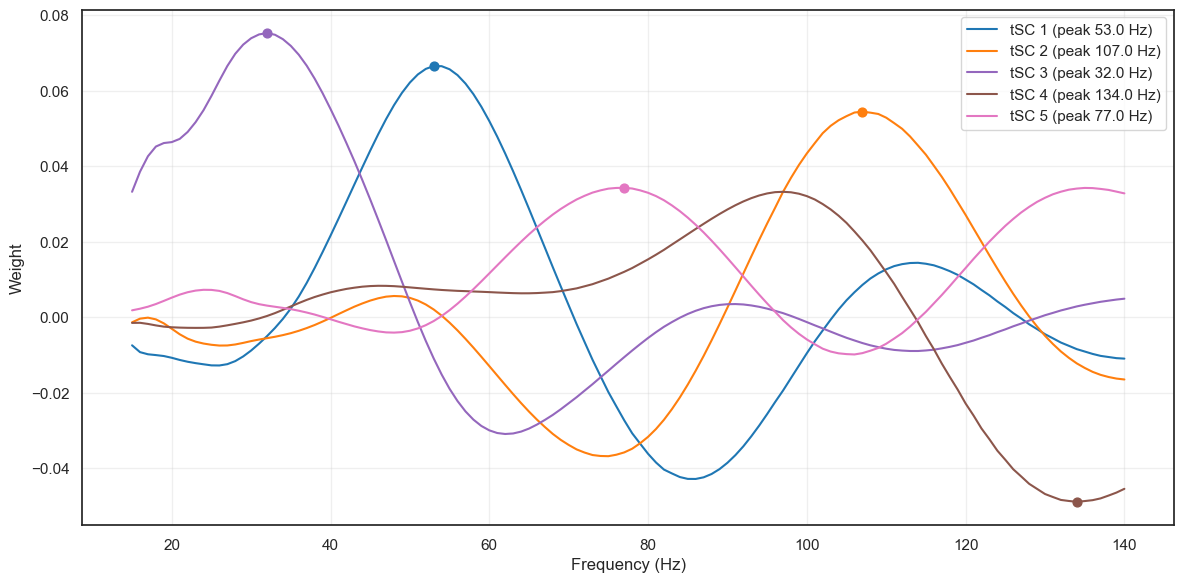

In [117]:
print_cycle_counts(cycles_df)
plot_tSC_weights(tSC_results["weights_freq"], tSC_results["freq_vec"])

In [131]:
def plot_mode_freq_histograms_per_component(
        df,
        col="mode_freq_hz_featZ_smooth",   # can be str or list[str]
        freq_bins=np.linspace(15, 140, 20),
        ymax=0.25,
        peaks_hz=None,              # optional: array of component peak freqs
        weights=None, freq_vec=None # or pass weights+freq_vec to compute peaks
    ):
    """
    Plot per-component histograms for phasic/tonic.
    `col` can be a single column name (str) or a list of column names to overlay.

    Recognized columns include:
      'mode_freq_hz_featZ', 'mode_freq_hz_featZ_smooth', 'mode_freq_hz_featZ_smooth10',
      'mode_freq_hz_featZ_smooth5_pad', 'mode_freq_hz_featZ_smooth10_pad',
      'mode_freq_hz_featZw', 'mode_freq_hz_proj'
    """
    # allow col to be list for overlays
    cols = [col] if isinstance(col, str) else list(col)
    palette = plt.cm.tab10(np.linspace(0, 1, max(10, len(cols))))

    comps = sorted(df["tSC_label"].dropna().unique().astype(int))

    # Derive peaks if not provided but weights+freq_vec are available
    if peaks_hz is None and (weights is not None) and (freq_vec is not None):
        weights = np.asarray(weights)
        freq_vec = np.asarray(freq_vec)
        peak_idx = np.argmax(np.abs(weights), axis=1)
        computed_peaks = freq_vec[peak_idx]
        peaks_map = {k+1: computed_peaks[k] for k in range(weights.shape[0])}
    else:
        peaks_map = {}
        if peaks_hz is not None:
            peaks_hz = np.asarray(peaks_hz)
            for i, p in enumerate(peaks_hz, start=1):
                peaks_map[i] = p

    for comp in comps:
        sub = df[df["tSC_label"] == comp]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        for j, ctype in enumerate(["phasic", "tonic"]):
            ax = axes[j]
            for ci, c in enumerate(cols):
                vals = sub.loc[sub["cycle_type"] == ctype, c].to_numpy(dtype=float)
                vals = vals[np.isfinite(vals)]
                if vals.size > 0:
                    weights_norm = np.ones_like(vals, dtype=float) / vals.size
                    ax.hist(vals, bins=freq_bins, weights=weights_norm,
                            alpha=0.5, color=palette[ci], label=c)
            ax.set_xlim(freq_bins.min(), freq_bins.max())
            ax.set_ylim(0, ymax)
            ax.set_xlabel("Mode frequency (Hz)")
            if j == 0:
                ax.set_ylabel("Probability")
            ax.set_title(f"tSC {comp} — {ctype.capitalize()}")

            # vertical line at component peak
            if comp in peaks_map and np.isfinite(peaks_map[comp]):
                pk = float(peaks_map[comp])
                ax.axvline(pk, ls="--", lw=2, color="k", alpha=0.9)
                ax.text(pk, ymax*0.95, f"{pk:.1f} Hz", ha="center", va="top")

            if j == 1:
                ax.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

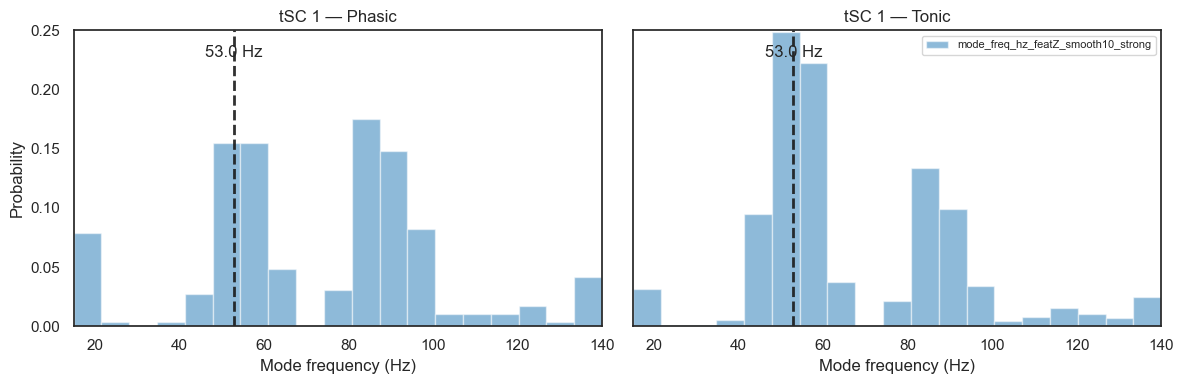

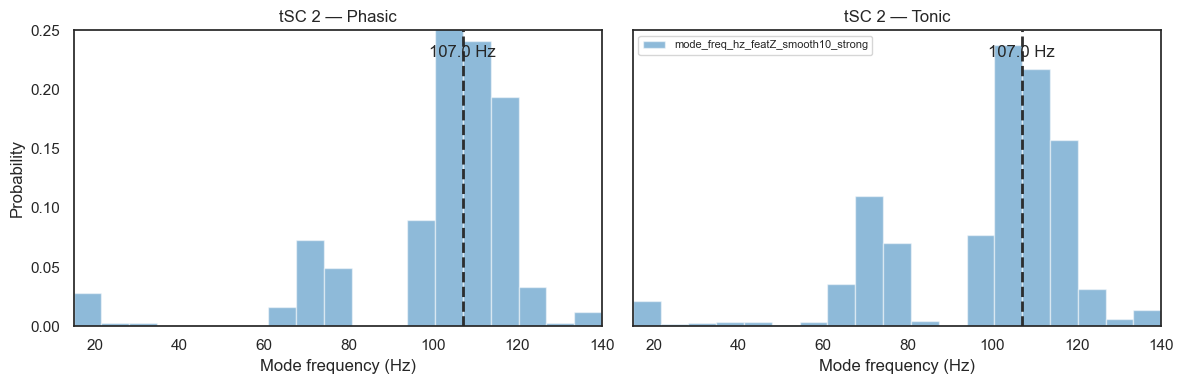

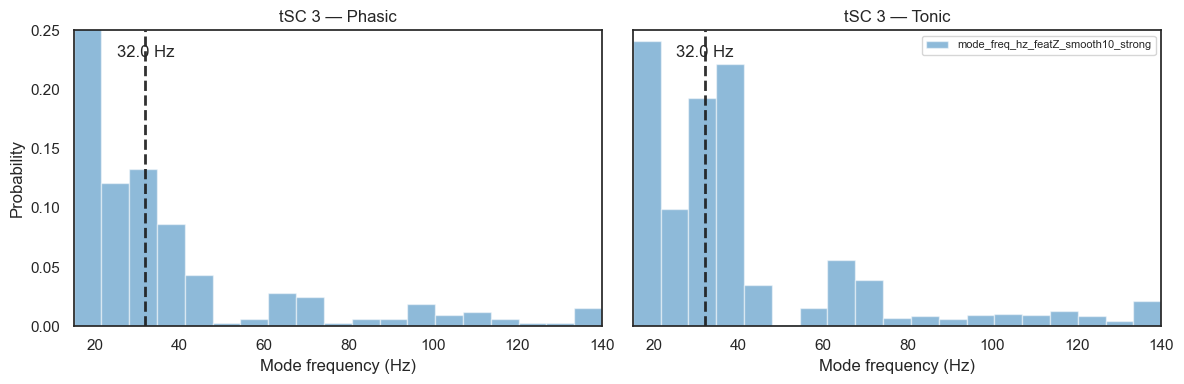

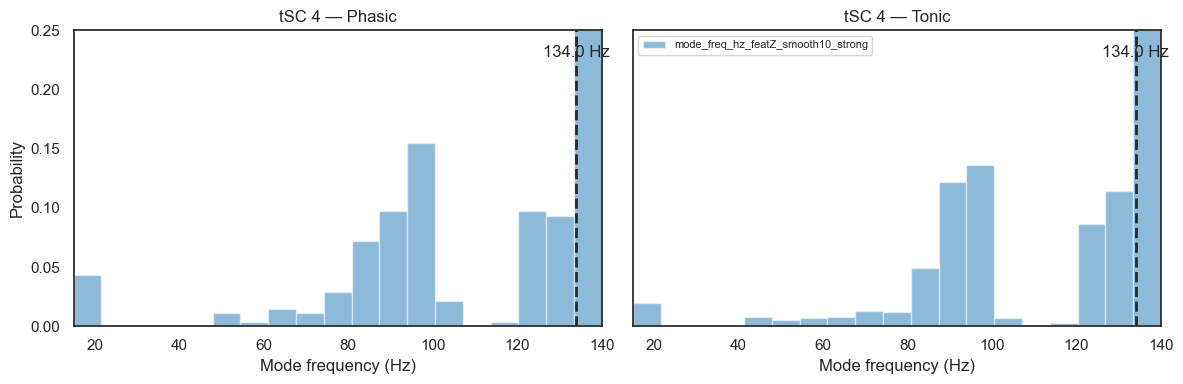

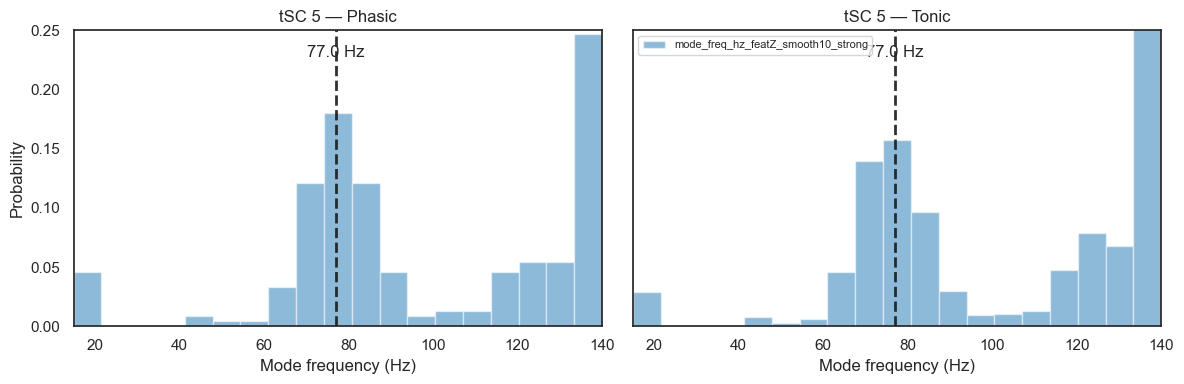

In [132]:
plot_mode_freq_histograms_per_component(
    cycles_df,
    col=["mode_freq_hz_featZ_smooth10_strong"],
    freq_bins=np.linspace(15, 140, 20),
    ymax=0.25,
    weights=tSC_results["weights_freq"],
    freq_vec=tSC_results["freq_vec"]
)

Added PCA scores + PCA/ICA probabilities to cycles_df
   PC1_score  PC2_score  PC3_score  PC4_score  PC5_score  PC1_prob  PC2_prob  \
0   3.634626   1.857167  -0.118602  -4.399503   1.179264  0.534926  0.125718   
1  33.594584  18.656834   4.261248 -10.600084   1.704386  0.999997  0.000003   
2  10.790369   2.841822  -0.495354 -11.111772   1.751332  0.962691  0.004649   
3   4.790451  -2.197034   2.715802  -5.976457   3.287646  0.599558  0.080687   
4   8.643620   2.403785  10.534893  -0.899761   5.667024  0.847912  0.012429   

       PC3_prob      PC4_prob      PC5_prob  PC_top   PC_conf     tSC1_prob  \
0  6.347774e-02  1.941267e-01  8.175178e-02       1  0.534926  6.056088e-02   
1  7.152307e-09  3.226001e-08  3.040705e-09       1  0.999997  3.424026e-07   
2  1.794539e-03  2.849023e-02  2.375424e-03       1  0.962691  1.151359e-02   
3  7.756161e-02  1.651532e-01  7.703985e-02       1  0.599558  1.738311e-02   
4  1.138496e-01  6.206403e-03  1.960300e-02       1  0.847912  8.45155

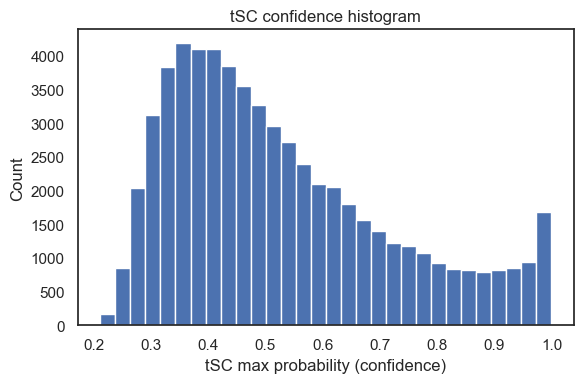

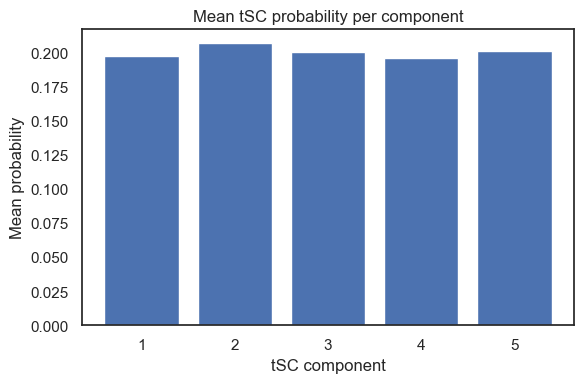

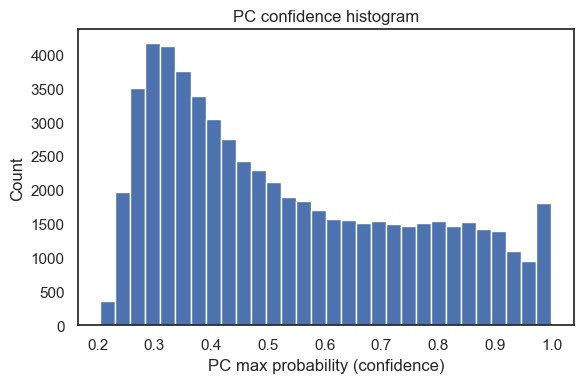

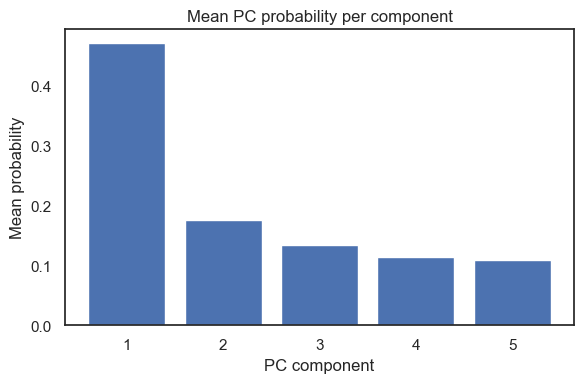

In [118]:
# ============================================================
# Add PCA scores + "likelihoods" (probabilities) for PCA & ICA
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------- pull from your results -------
pca        = tSC_results["pca"]
ica        = tSC_results["ica"]
X_featZ    = tSC_results["X_cycles_featZ"]   # the same features the PCA was fit on
S          = tSC_results["strengths"]        # (n_cycles × n_pca) = ICA source strengths
evr        = pca.explained_variance_ratio_   # (n_pca,)
n_pca      = S.shape[1]

# safety
assert X_featZ.shape[0] == cycles_df.shape[0], "Row mismatch: X_featZ vs cycles_df"
assert S.shape[0]       == cycles_df.shape[0], "Row mismatch: S vs cycles_df"

# ------- recompute PCA scores (Z) for all cycles -------
Z = pca.transform(X_featZ)   # (n_cycles × n_pca)

# ------------------------------------------------------------
# helpers for probabilities ("likelihoods")
# ------------------------------------------------------------
def _softmax(a, axis=1, tau=1.0):
    # numerically-stable softmax with temperature
    a = np.asarray(a, dtype=float)
    if tau <= 0:
        tau = 1.0
    m = np.max(a, axis=axis, keepdims=True)
    e = np.exp((a - m) / tau)
    return e / (e.sum(axis=axis, keepdims=True) + 1e-12)

def _mad_scale(x, axis=0):
    # robust sigma ~ MAD/0.6745
    med = np.median(x, axis=axis, keepdims=True)
    mad = np.median(np.abs(x - med), axis=axis, keepdims=True)
    return (mad / 0.6745) + 1e-12

# ------------------------------------------------------------
# A) ICA/tSC probabilities
# ------------------------------------------------------------
# Option 1: plain |S|
S_abs = np.abs(S)

# Option 2 (recommended): scale each component by its robust std (MAD)
S_sigma = _mad_scale(S_abs, axis=0)              # (1 × n_pca)
S_abs_mad = S_abs / S_sigma                      # component-wise normalization

tau_ica = 1.0   # temperature for softmax (lower -> more "peaky")
probs_tSC_plain = _softmax(S_abs,     axis=1, tau=tau_ica)
probs_tSC_mad   = _softmax(S_abs_mad, axis=1, tau=tau_ica)

# choose which one to keep as your "official" probability
probs_tSC = probs_tSC_mad    # <-- pick MAD-normalized by default

# argmax label, confidence & entropy
tSC_top_idx   = np.argmax(probs_tSC, axis=1)              # 0-based
tSC_conf      = probs_tSC[np.arange(probs_tSC.shape[0]), tSC_top_idx]
tSC_entropy   = -(probs_tSC * np.log(probs_tSC + 1e-12)).sum(axis=1)

# ------------------------------------------------------------
# B) PCA probabilities
# ------------------------------------------------------------
# Two sensible flavors; pick one:
#  B1) variance-weighted |Z|   (|Z_k| * sqrt(EVR_k))
#  B2) variance-weighted power (Z_k^2 * EVR_k)
w_sqrt = np.sqrt(evr)[None, :]         # (1 × n_pca)
w_evr  = evr[None, :]                  # (1 × n_pca)

pca_score_mag = np.abs(Z) * w_sqrt     # B1
pca_score_pow = (Z**2)   * w_evr       # B2

tau_pca = 1.0
probs_PC_mag = _softmax(pca_score_mag, axis=1, tau=tau_pca)
probs_PC_pow = _softmax(pca_score_pow, axis=1, tau=tau_pca)

# choose your "official" PCA prob
probs_PC = probs_PC_mag

PC_top_idx = np.argmax(probs_PC, axis=1)
PC_conf    = probs_PC[np.arange(probs_PC.shape[0]), PC_top_idx]
PC_entropy = -(probs_PC * np.log(probs_PC + 1e-12)).sum(axis=1)

# ------------------------------------------------------------
# C) Write everything back into cycles_df
# ------------------------------------------------------------
# PCA scores
for k in range(n_pca):
    cycles_df[f"PC{k+1}_score"] = Z[:, k]

# PCA probabilities
for k in range(n_pca):
    cycles_df[f"PC{k+1}_prob"]      = probs_PC[:, k]
    cycles_df[f"PC{k+1}_prob_pow"]  = probs_PC_pow[:, k]   # optional alt flavor

cycles_df["PC_top"]       = (PC_top_idx + 1).astype(int)
cycles_df["PC_conf"]      = PC_conf
cycles_df["PC_entropy"]   = PC_entropy

# ICA/tSC probabilities
for k in range(n_pca):
    cycles_df[f"tSC{k+1}_prob"]        = probs_tSC[:, k]        # MAD-normalized (chosen)
    cycles_df[f"tSC{k+1}_prob_plain"]  = probs_tSC_plain[:, k]  # plain |S| softmax (reference)
    cycles_df[f"tSC{k+1}_zmad"]        = S_abs_mad[:, k]        # |S| normalized by MAD (diagnostic)

cycles_df["tSC_top"]      = (tSC_top_idx + 1).astype(int)
cycles_df["tSC_conf"]     = tSC_conf
cycles_df["tSC_entropy"]  = tSC_entropy

print("Added PCA scores + PCA/ICA probabilities to cycles_df")
print(cycles_df.filter(regex=r'^(PC\d+_score|PC\d+_prob|tSC\d+_prob|tSC_top|tSC_conf|PC_top|PC_conf)$').head())

# ------------------------------------------------------------
# D) (Optional) quick sanity plots
# ------------------------------------------------------------
def plot_prob_summaries(cycles_df, comp_type="tSC", n_comp=n_pca):
    fig, ax = plt.subplots(figsize=(6,4))
    conf = cycles_df[f"{comp_type}_conf"].to_numpy()
    ax.hist(conf[np.isfinite(conf)], bins=30)
    ax.set_xlabel(f"{comp_type} max probability (confidence)")
    ax.set_ylabel("Count")
    ax.set_title(f"{comp_type} confidence histogram")
    plt.tight_layout(); plt.show()

    # mean probability across cycles per component (should be ~uniform if labels balanced)
    means = [cycles_df[f"{comp_type}{k+1}_prob"].mean() for k in range(n_comp)]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(np.arange(1, n_comp+1), means)
    ax.set_xlabel(f"{comp_type} component")
    ax.set_ylabel("Mean probability")
    ax.set_title(f"Mean {comp_type} probability per component")
    plt.tight_layout(); plt.show()

plot_prob_summaries(cycles_df, comp_type="tSC", n_comp=n_pca)
plot_prob_summaries(cycles_df, comp_type="PC",  n_comp=n_pca)

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_single_cycle_tSC(cycle_idx,
                          tSC_results,
                          cycles_df,
                          topk_components=3,
                          show_all_weights=False   # True => plot weights for all components
                         ):
    """
    One-cycle visualization:
      (A1) raw signature + z-scored signature (twin y-axes), with dashed line at mode_freq_hz_featZ_smooth
      (A2) z-scored signature (red) + selected tSC weight curves (raw W_k), with peak markers
      (B1) tSC probability bars
      (B2) projection profiles: (within-cycle Z) × |W_k|
    """
    # ---------- pull from results ----------
    freq_vec   = np.asarray(tSC_results["freq_vec"])
    X_raw      = np.asarray(tSC_results["X_cycles"])           
    X_featZ    = np.asarray(tSC_results["X_cycles_featZ"])     
    W_freq     = np.asarray(tSC_results["weights_freq"])       
    S          = np.asarray(tSC_results["strengths"])          
    thr_absS   = np.asarray(tSC_results["thresholds_abs_strength"])
    n_comp     = W_freq.shape[0]

    assert 0 <= cycle_idx < X_raw.shape[0], f"cycle_idx out of bounds [0, {X_raw.shape[0]-1}]"

    x_raw = X_raw[cycle_idx]
    xz    = X_featZ[cycle_idx]
    s_row = S[cycle_idx]

    # ---------- mode frequency (from smoothed feature-Z) ----------
    if "mode_freq_hz_featZ_smooth" in cycles_df.columns:
        mode_hz = cycles_df.loc[cycle_idx, "mode_freq_hz_featZ_smooth"]
    else:
        # fallback
        idx = int(np.argmax(xz))
        mode_hz = float(freq_vec[idx])

    # ---------- choose which components to plot ----------
    prob_cols = [f"tSC{k+1}_prob" for k in range(n_comp) if f"tSC{k+1}_prob" in cycles_df.columns]
    if len(prob_cols) == n_comp:
        probs = cycles_df.loc[cycle_idx, prob_cols].to_numpy(dtype=float)
        order = np.argsort(probs)[::-1]
    else:
        probs = None
        order = np.argsort(np.abs(s_row))[::-1]

    comps_to_show = list(range(n_comp)) if show_all_weights else list(order[:min(topk_components, n_comp)])

    # ---------- palettes (no greens) ----------
    weight_palette = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#17becf',  # cyan
        '#ff9896',  # light red
        '#bc82bd',  # mauve
    ]

    # ---------- layout ----------
    fig = plt.figure(figsize=(13, 9))
    gs  = GridSpec(2, 2, height_ratios=[1.0, 1.0], width_ratios=[1.3, 1.0],
                   hspace=0.30, wspace=0.25)

    # (A1) raw signature (left y) + z-scored signature (right y) + dashed mode line
    axA1 = fig.add_subplot(gs[0, 0])
    ln1, = axA1.plot(freq_vec, x_raw, lw=2, color="k", label="Raw signature")
    axA1.set_xlabel("Frequency (Hz)")
    axA1.set_ylabel("Amplitude (a.u.)", color="k")
    axA1.tick_params(axis='y', labelcolor='k')
    axA1.set_title(f"Cycle {cycle_idx} — Raw + Z-scored spectral signatures")

    axA1r = axA1.twinx()
    ln2, = axA1r.plot(freq_vec, xz, lw=2, color="#d62728", label="Z-scored signature")  # RED
    axA1r.axvline(mode_hz, color="#d62728", ls="--", lw=2, label=f"Mode (smoothed) ~{mode_hz:.1f} Hz")
    axA1r.set_ylabel("Z-score", color="#d62728")
    axA1r.tick_params(axis='y', labelcolor="#d62728")

    # unified legend
    axA1.legend([ln1, ln2], ["Raw signature", "Z-scored signature"], loc="upper right", frameon=True)
    axA1r.legend(loc="upper left", frameon=True)

    # (A2) within-cycle Z (red) + raw tSC weight curves (right y-axis)
    axA2 = fig.add_subplot(gs[1, 0])
    axA2.plot(freq_vec, xz, lw=2, color="#d62728", label="Z-scored signature")  # RED
    axA2.set_xlabel("Frequency (Hz)")
    axA2.set_ylabel("Z-score", color="#d62728")
    axA2.tick_params(axis='y', labelcolor="#d62728")
    axA2.set_title("Within-cycle Z signature + selected tSC weights")

    axA2r = axA2.twinx()
    lines_w, labels_w = [], []
    for i, k in enumerate(comps_to_show):
        color = weight_palette[i % len(weight_palette)]
        w = W_freq[k]
        lnw, = axA2r.plot(freq_vec, w, lw=2, color=color, label=f"tSC {k+1} weight")
        pk_idx = int(np.argmax(np.abs(w)))
        axA2r.scatter([freq_vec[pk_idx]], [w[pk_idx]], s=40, color=color, zorder=5)
        lines_w.append(lnw); labels_w.append(f"tSC {k+1} weight (peak ~{freq_vec[pk_idx]:.0f} Hz)")
    axA2r.set_ylabel("tSC weight (a.u.)")

    L1, lab1 = axA2.get_legend_handles_labels()
    L2, lab2 = lines_w, labels_w
    axA2.legend(L1 + L2, lab1 + lab2, fontsize=9, ncol=1, frameon=True, loc="upper right")

    # (B1) tSC probabilities bar plot
    axB1 = fig.add_subplot(gs[0, 1])
    if probs is None:
        s_abs = np.abs(s_row)
        e = np.exp(s_abs - np.max(s_abs))
        probs = e / (e.sum() + 1e-12)
    axB1.bar(np.arange(1, n_comp+1), probs, color="#1f77b4", alpha=0.9)  # blue
    axB1.set_xticks(np.arange(1, n_comp+1))
    axB1.set_ylim(0, 1.0)
    axB1.set_xlabel("tSC component")
    axB1.set_ylabel("Probability")
    axB1.set_title("Cycle’s probability of belonging to each tSC")

    top = int(np.argmax(probs))
    conf = float(probs[top])
    note = [f"Top tSC: {top+1}", f"Conf.: {conf:.3f}", f"S_k: {np.array2string(s_row, precision=3)}"]
    if thr_absS is not None and thr_absS.size == n_comp:
        strong_flags = (np.abs(s_row) >= thr_absS)
        note.append(f"Strong flags: {strong_flags.astype(int)}")
    axB1.text(0.02, 0.98, "\n".join(note), transform=axB1.transAxes,
              va='top', ha='left', fontsize=9,
              bbox=dict(boxstyle="round", fc="w", ec="0.7", alpha=0.95))

    # (B2) projection profiles (Z × |W|)
    axB2 = fig.add_subplot(gs[1, 1])
    for i, k in enumerate(comps_to_show):
        color = weight_palette[i % len(weight_palette)]
        y = xz * np.abs(W_freq[k])
        axB2.plot(freq_vec, y, lw=2, color=color, label=f"tSC {k+1}")
        idx = int(np.argmax(y))
        axB2.axvline(freq_vec[idx], color=color, ls='--', alpha=0.6)
    axB2.set_xlabel("Frequency (Hz)")
    axB2.set_ylabel("Projection profile (Z × |W|)")
    axB2.set_title("Projection profiles contributing to the dot product")
    axB2.legend(fontsize=9, frameon=True)

    fig.suptitle("Single-cycle tSC summary", y=0.995, fontsize=14)
    plt.tight_layout()
    plt.show()

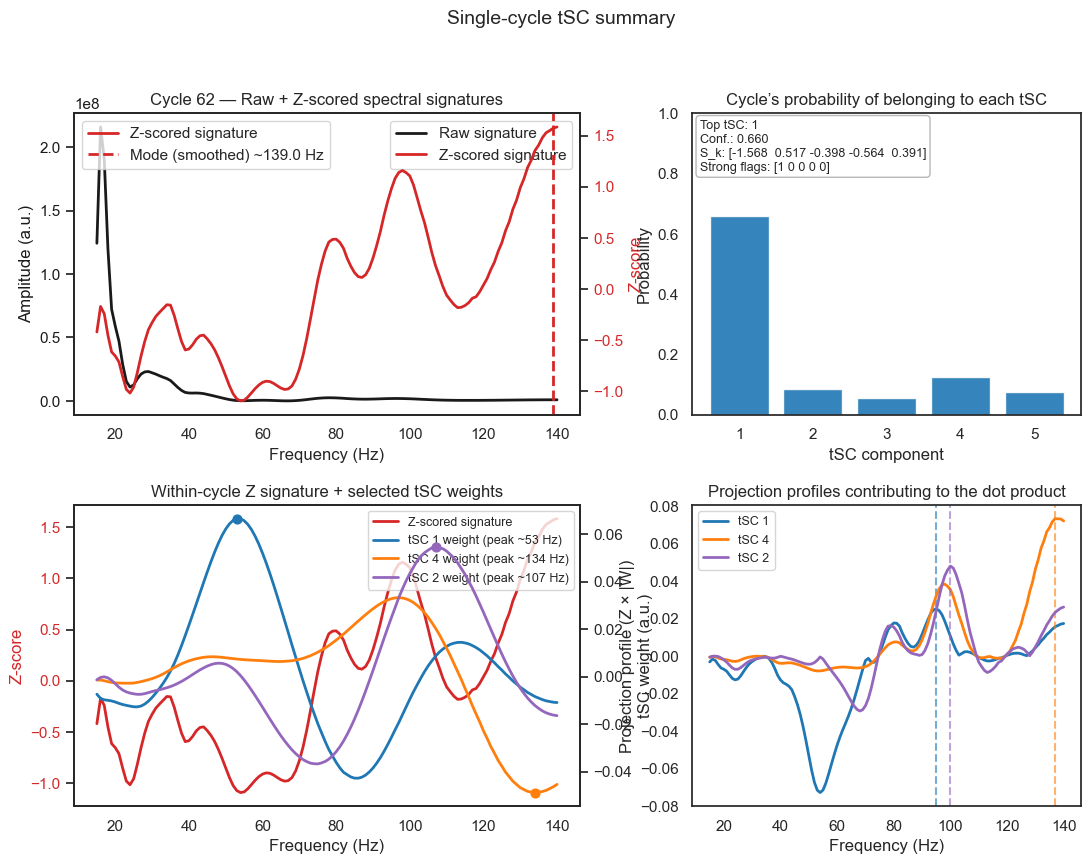

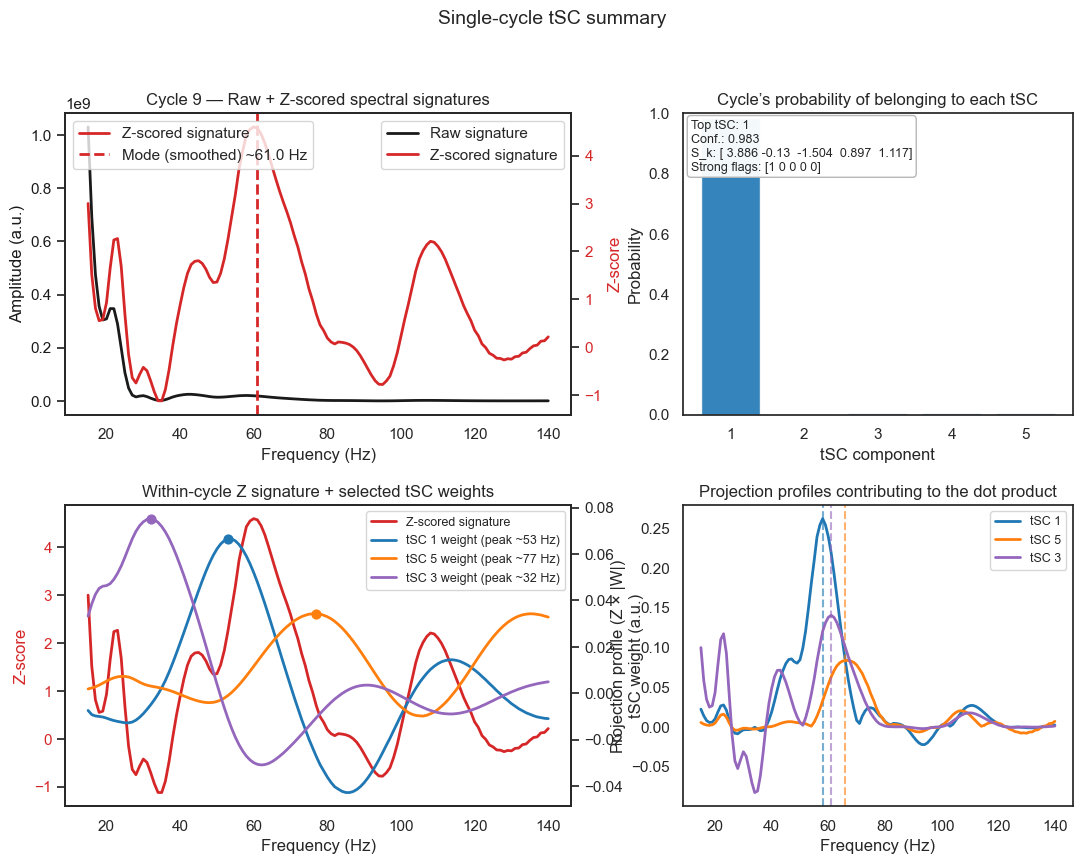

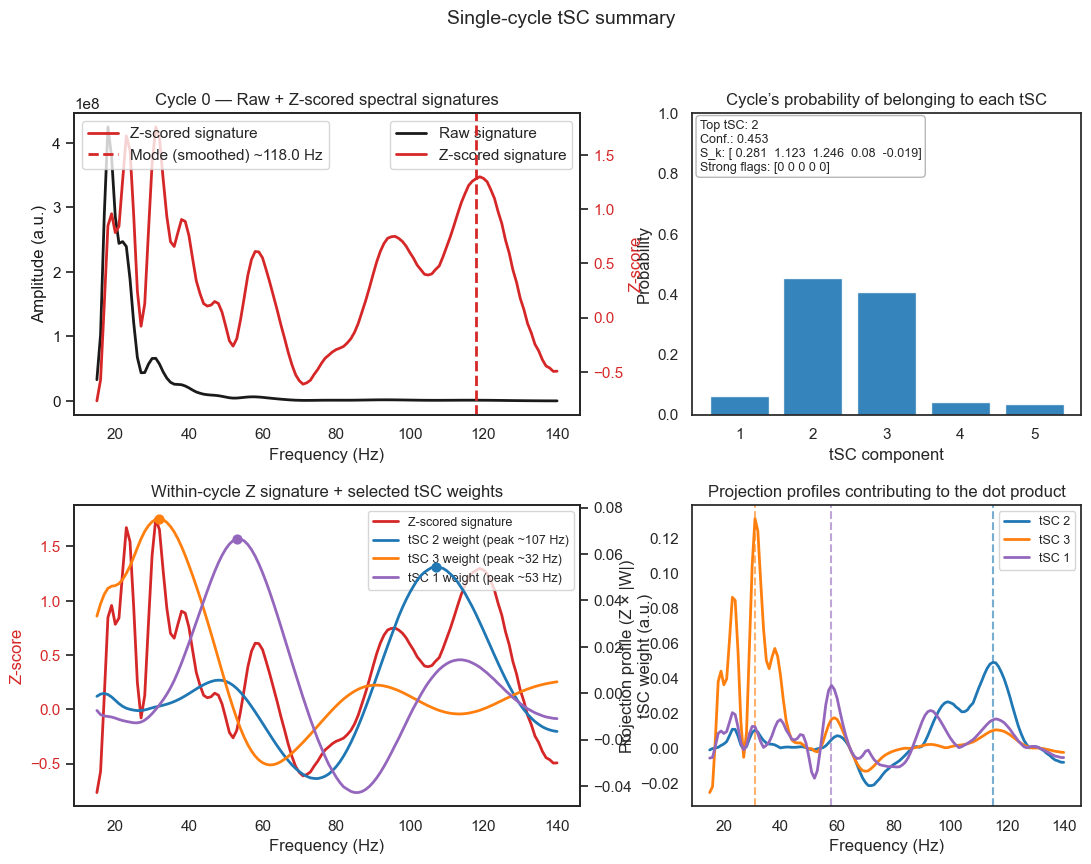

In [140]:
for i in [num for num in np.random.randint(0, 100, size=3)]:
    idx0 = cycles_df.index[cycles_df["cycle_type"] == "phasic"][i]
    plot_single_cycle_tSC(idx0, tSC_results, cycles_df, topk_components=3)

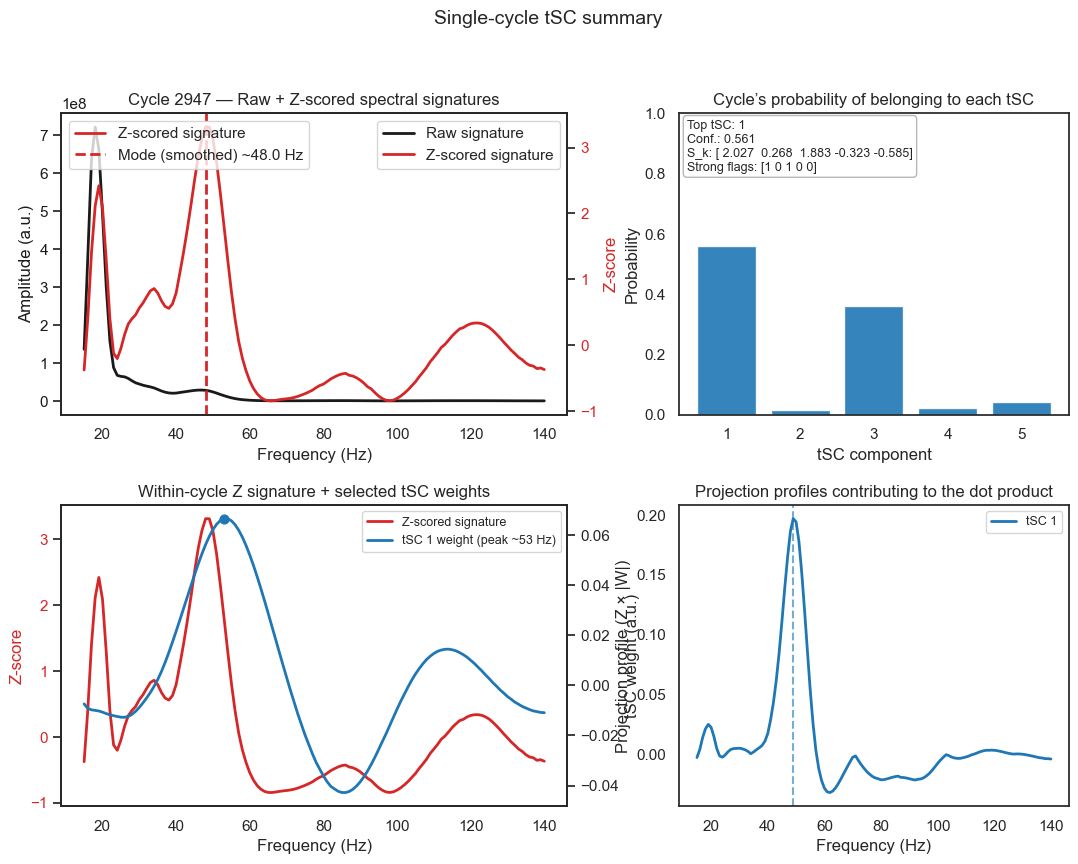

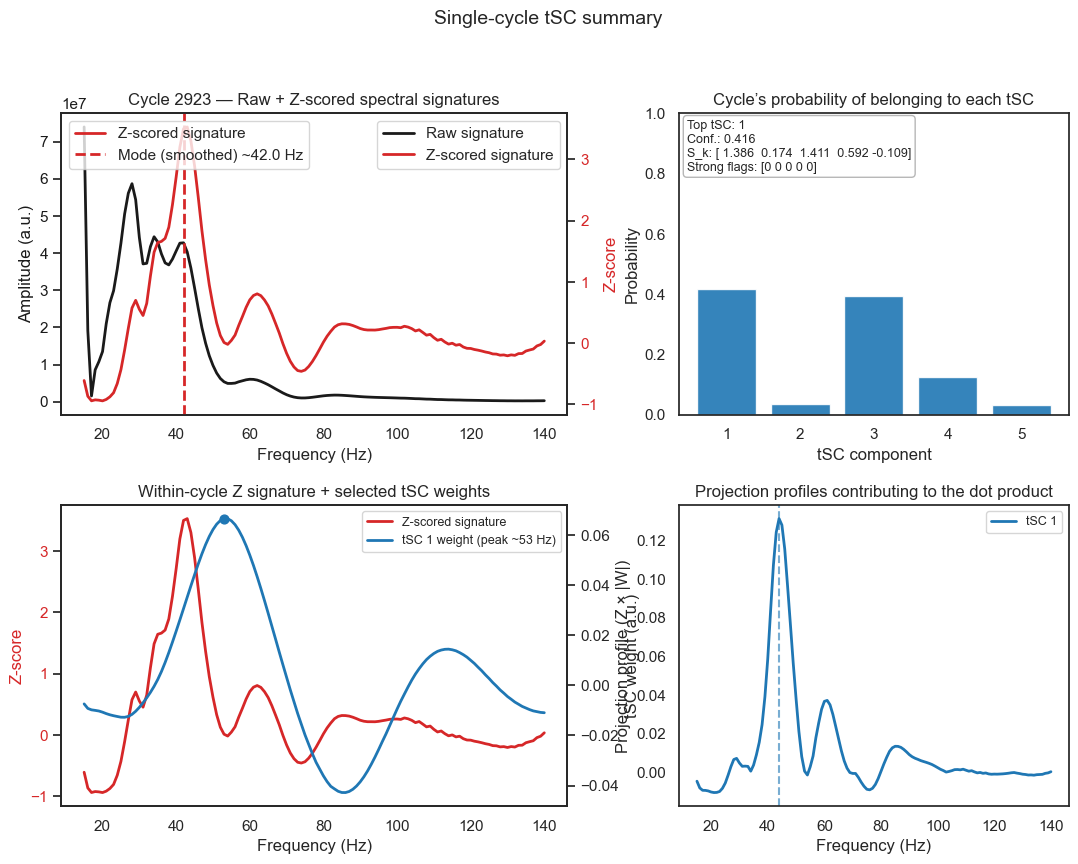

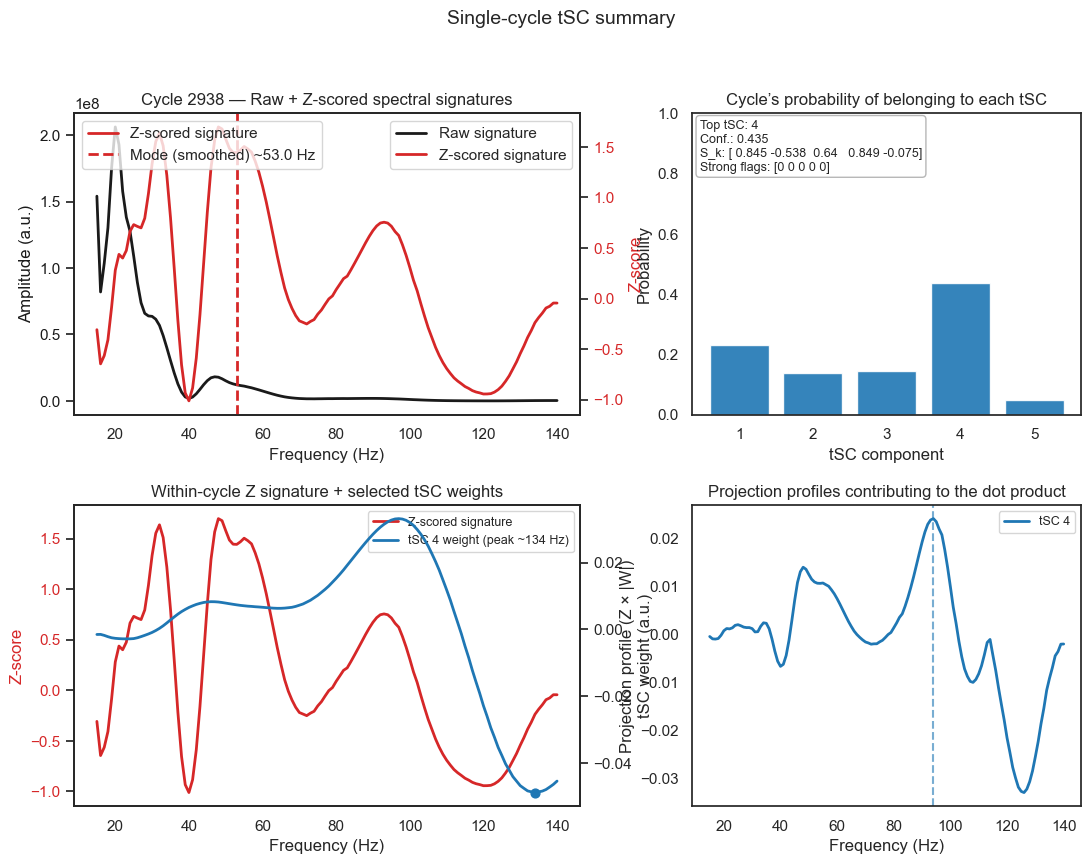

In [141]:
for i in [num for num in np.random.randint(0, 100, size=3)]:
    idx0 = cycles_df.index[cycles_df["cycle_type"] == "tonic"][i]
    plot_single_cycle_tSC(idx0, tSC_results, cycles_df, topk_components=1)

# temp topology

In [26]:
import os
import numpy as np
import pandas as pd

# Optional smoothing util (uses SciPy if available; otherwise a small Gaussian conv fallback)
try:
    from scipy.ndimage import gaussian_filter1d
    _HAS_SCI = True
except Exception:
    _HAS_SCI = False

def _smooth_rows(mat, sigma_hz, mode="reflect"):
    if _HAS_SCI:
        return gaussian_filter1d(mat, sigma=float(sigma_hz), axis=1, mode=mode)
    # fallback conv
    sigma = float(sigma_hz)
    rad = int(np.ceil(4 * sigma))
    kx = np.arange(-rad, rad + 1)
    ker = np.exp(-(kx**2) / (2 * sigma**2))
    ker /= ker.sum()
    pad = rad
    out = np.empty_like(mat)
    for i in range(mat.shape[0]):
        row = mat[i]
        if mode == "reflect":
            row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
        elif mode == "constant":
            row_pad = np.r_[np.zeros(pad), row, np.zeros(pad)]
        else:
            row_pad = np.r_[row[pad:0:-1], row, row[-2:-pad-2:-1]]
        out[i] = np.convolve(row_pad, ker, mode="same")[pad:-pad]
    return out

def compute_mode_freq_featZ_smooth_for_session_imfs(
    imfs, imf_frequencies, fs=2500, theta_band=(5,12),
    freq_vec=np.arange(15,141,1), wavelet_ncycles=5,
    smooth_sigma_hz=5.0, ignore_edge_bins=1, theta_imf_index_prefer=5
):
    """
    For a list of IMFs (one per segment) from a single session:
      1) detect theta cycles with your conditions
      2) compute per-cycle time-mean spectral signatures on supra-theta (15–140 Hz)
      3) Z-score across cycles (per frequency), smooth across frequency
      4) pick the mode frequency from the smoothed Z (ignoring first/last bins if desired)
    Returns:
      modes_hz : np.ndarray (n_cycles,)   -- mode_freq_hz_featZ_smooth for each kept cycle
      idx_map  : list of (interval_idx, local_cycle_idx) tuples (same order as modes_hz)
      X_raw    : np.ndarray (n_cycles, n_freq) raw time-mean signatures (optional inspection)
      Xz_smooth: np.ndarray (n_cycles, n_freq) smoothed Z (what we used to pick the mode)
    """
    rows = []
    idx_map = []

    for idx, imf in enumerate(imfs):
        # 1) choose theta IMF index
        if imf.shape[1] > theta_imf_index_prefer:
            theta_idx = theta_imf_index_prefer
        else:
            theta_idx = _choose_theta_imf(imf, fs, theta_band=theta_band)

        # 2) cycles with your conditions
        cycle_data = get_cycle_data(imf[:, theta_idx], fs=fs)
        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/12
        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']
        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
        if all_cycles is None or all_cycles.chain_vect.size == 0:
            continue

        subset_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_df['index'].values
        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds     = arrange_cycle_inds(all_cycles_inds)
        tids_list      = _cycle_time_indices_from_bins(cycles_inds)

        # 3) supra-theta signal (sum of IMFs with mean freq > 12 Hz)
        freqs = imf_frequencies[idx]
        _, theta_mask, supra_mask = tg_split(freqs, theta_band)
        supra_theta_sig = imf[:, supra_mask].sum(axis=1) if np.any(supra_mask) else np.zeros(imf.shape[0])

        # 4) per-cycle time-mean spectral signatures (15–140 Hz)
        sigs_time, _tf = _spectral_signatures_time_mean(
            supra_theta_sig, fs, tids_list, freqs=freq_vec, wavelet_ncycles=wavelet_ncycles
        )  # (n_cycles_i × n_freq)

        # keep finite rows only; remember mapping
        if sigs_time.size:
            mask = np.isfinite(sigs_time).all(axis=1)
            Xi = sigs_time[mask]
            if Xi.size:
                start_j = len(idx_map)
                rows.append(Xi)
                for j in range(Xi.shape[0]):
                    idx_map.append((idx, j))  # interval idx & local cycle idx

    if len(rows) == 0:
        return np.zeros((0,)), [], np.zeros((0, len(freq_vec))), np.zeros((0, len(freq_vec)))

    X = np.vstack(rows)                       # raw cycle signatures
    # 5) feature Z across cycles (per frequency)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, ddof=1, keepdims=True) + 1e-12
    Xz = (X - mu) / sd

    # 6) smooth across frequency
    Xz_smooth = _smooth_rows(Xz, sigma_hz=smooth_sigma_hz, mode="reflect")

    # 7) pick mode (ignore edges if requested)
    L, R = ignore_edge_bins, (Xz_smooth.shape[1] - ignore_edge_bins)
    if R > L:
        idx_rel = np.argmax(Xz_smooth[:, L:R], axis=1)
        idx_max = idx_rel + L
    else:
        idx_max = np.argmax(Xz_smooth, axis=1)
    modes_hz = freq_vec[idx_max]

    return modes_hz, idx_map, X, Xz_smooth

# ========== RUN FOR YOUR ONE SESSION ==========
# You already created:
# lfpHPC, hypno, fs = get_data(...)
# phasic_interval, tonic_interval, lfp = extract_pt_intervals(...)
# tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(...)
# phasic_imfs, phasic_imfs_freqs, rem_lpf     = extract_imfs_by_pt_intervals(...)

# Compute mode_freq_hz_featZ_smooth per cycle (phasic & tonic)
phasic_modes_hz, phasic_idx_map, phasic_X, phasic_Xz_smooth = compute_mode_freq_featZ_smooth_for_session_imfs(
    phasic_imfs, phasic_imfs_freqs, fs=fs, theta_band=(5,12),
    freq_vec=np.arange(15,141,1), wavelet_ncycles=5, smooth_sigma_hz=5.0, ignore_edge_bins=1,
    theta_imf_index_prefer=5
)
tonic_modes_hz,  tonic_idx_map,  tonic_X,  tonic_Xz_smooth  = compute_mode_freq_featZ_smooth_for_session_imfs(
    tonic_imfs, tonic_imfs_freqs, fs=fs, theta_band=(5,12),
    freq_vec=np.arange(15,141,1), wavelet_ncycles=5, smooth_sigma_hz=5.0, ignore_edge_bins=1,
    theta_imf_index_prefer=5
)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs 

In [27]:
def get_cycle_inds(cycles, subset_indices):

    all_cycles_inds = []
    for idx in subset_indices:
        if idx != -1:
            inds = cycles.get_inds_of_cycle(idx, mode='cycle')
            all_cycles_inds.append(inds)
    return all_cycles_inds

In [28]:
import os
import numpy as np

def package_modes_per_interval(
    imfs, imf_frequencies, fs,
    modes_hz_all, idx_map,                # from compute_mode_freq_featZ_smooth_for_session_imfs(...)
    theta_band=(5, 12), theta_imf_index_prefer=5,
    freq_vec=np.arange(15,141,1), wavelet_ncycles=5
):
    """
    Build one dict per interval with:
      - interval_idx
      - theta_imf_index (used)
      - theta_imf (1D array)
      - cycle_time_indices: list[np.ndarray]   # time indices for each detected cycle (trough->trough bins)
      - kept_mask: bool array (which cycles survived finite-signature filtering)
      - mode_freq_hz_featZ_smooth: float array (len = n_cycles) with NaN for dropped cycles
    """
    out = []

    # A tiny helper that duplicates your earlier steps so masks/ordering match
    for interval_idx, imf in enumerate(imfs):
        # 1) choose theta-IMF
        if imf.shape[1] > theta_imf_index_prefer:
            theta_idx = theta_imf_index_prefer
        else:
            theta_idx = _choose_theta_imf(imf, fs, theta_band=theta_band)

        theta_trace = imf[:, theta_idx]
        n_samples   = len(theta_trace)

        # 2) detect cycles (same conditions you’ve been using)
        cycle_data = get_cycle_data(theta_trace, fs=fs)
        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/12
        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']
        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
        if all_cycles is None or all_cycles.chain_vect.size == 0:
            # still produce an empty record for this interval
            out.append(dict(
                interval_idx=interval_idx,
                theta_imf_index=theta_idx,
                theta_imf=theta_trace,
                cycle_time_indices=[],
                kept_mask=np.zeros(0, dtype=bool),
                mode_freq_hz_featZ_smooth=np.zeros(0, dtype=float)
            ))
            continue

        subset_df  = all_cycles.get_metric_dataframe(subset=True)
        subset_idx = subset_df['index'].values

        all_inds   = get_cycle_inds(all_cycles, subset_idx)   # list of arrays (bins/indices)
        cycles_inds= arrange_cycle_inds(all_inds)             # list of per-cycle bins
        tids_list  = _cycle_time_indices_from_bins(cycles_inds)  # list of 1D integer time indices

        # 3) rebuild supra-theta signatures to get the *kept* mask (finite rows)
        freqs = imf_frequencies[interval_idx]
        _, theta_mask, supra_mask = tg_split(freqs, theta_band)
        supra_theta_sig = imf[:, supra_mask].sum(axis=1) if np.any(supra_mask) else np.zeros(n_samples)

        sigs_time, _ = _spectral_signatures_time_mean(
            supra_theta_sig, fs, tids_list, freqs=freq_vec, wavelet_ncycles=wavelet_ncycles
        )
        kept_mask = np.isfinite(sigs_time).all(axis=1) if sigs_time.size else np.zeros(len(tids_list), dtype=bool)

        # 4) pull the per-interval modes from modes_hz_all+idx_map (in kept order)
        modes_this = [modes_hz_all[i] for i, (idx, _local) in enumerate(idx_map) if idx == interval_idx]
        modes_this = np.asarray(modes_this, dtype=float)

        # 5) build a full-length vector (one value per detected cycle; NaN for dropped)
        mode_full = np.full(len(tids_list), np.nan, dtype=float)
        kept_idx_in_interval = np.nonzero(kept_mask)[0]

        if modes_this.size and kept_idx_in_interval.size:
            m = min(modes_this.size, kept_idx_in_interval.size)  # guard just in case
            mode_full[kept_idx_in_interval[:m]] = modes_this[:m]

        out.append(dict(
            interval_idx=interval_idx,
            theta_imf=theta_trace,
            cycle_time_indices=[np.asarray(tids, dtype=int) for tids in tids_list],
            kept_mask=kept_mask.astype(bool),
            mode_freq_hz_featZ_smooth=mode_full
        ))

    return out

# ---------- Build packages for this session ----------
phasic_packages = package_modes_per_interval(
    phasic_imfs, phasic_imfs_freqs, fs,
    phasic_modes_hz, phasic_idx_map,
    theta_band=(5,12), theta_imf_index_prefer=5
)
tonic_packages  = package_modes_per_interval(
    tonic_imfs, tonic_imfs_freqs, fs,
    tonic_modes_hz, tonic_idx_map,
    theta_band=(5,12), theta_imf_index_prefer=5
)

# Quick sanity check on one interval
print("Phasic interval 0 keys:", phasic_packages[0].keys())
print("Cycles in phasic interval 0:", len(phasic_packages[0]["cycle_time_indices"]))
print("Modes vector length (should match cycles):", len(phasic_packages[0]["mode_freq_hz_featZ_smooth"]))

# ---------- Save them (pickle or npz) ----------
import pickle, pathlib

session_name = os.path.splitext(os.path.basename(path_to_states))[0]
base_dir = pathlib.Path(os.getcwd()).resolve().parent / "data" / f"{session_name}_per_interval_modes"
base_dir.mkdir(parents=True, exist_ok=True)

# Pickle (simple & faithful)
with open(base_dir / "phasic_packages.pkl", "wb") as f:
    pickle.dump(phasic_packages, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(base_dir / "tonic_packages.pkl", "wb") as f:
    pickle.dump(tonic_packages, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved per-interval packages to: {base_dir}")

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs 

In [30]:
phasic_packages[0]

{'interval_idx': 0,
 'theta_imf': array([ -67.53567563,  -68.67820055,  -69.60273623, ..., -350.9241874 ,
        -345.794871  , -340.43099016]),
 'cycle_time_indices': [array([666, 995]),
  array([ 996, 1241]),
  array([1242, 1502]),
  array([1503, 1751]),
  array([1752, 2047]),
  array([2048, 2317]),
  array([2318, 2576]),
  array([2577, 2851])],
 'kept_mask': array([ True,  True,  True,  True,  True,  True,  True,  True]),
 'mode_freq_hz_featZ_smooth': array([ 39.,  16.,  28.,  29., 103.,  81.,  82.,  29.])}